# Advanced Structural Analysis and Dynamics 5
## Course Work 2 - Dynamics
2401456t - Mihail Todorov

# Submission requirements
## Report 
The report document should clearly and logically address all the tasks. 
Marks will be deducted for poor presentation. 
The report is to be submitted on-line via Moodle - hard-copies will not be marked.

You are to write the report using Google Colab / Jupyer notebook or similar software. 

You need to submit a single compressed file (zip or similar) containing:
* the *main_dynamics.ipynb* containing both the write up and code.
* the saved `npz` data files so that I can reproduce your results.
* A pdf print of the *main_dynamics.ipynb* containing the write up and code.

No other documents will be accepted.

Please make sure to use the `local_path` variable to set the path.
This will ensure that I can easily run your code on my computer. 

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# import all of the required libraries 

import numpy as np
import matplotlib.pyplot as plt
import math
import plotly as pl
import plotly.graph_objects as go
import seaborn
import pandas

# the following code will allow to access the local_path to the working file director where all of the result files are saved
import os
local_path = os.getcwd()

In [3]:
# test if the local path works properly
# all future file paths will be added on top of the local path and will be tested in a similar fashion, if you would like to change the local path please do so hear,
# change it to the root directory where all of the data files are saved.
local_path

'C:\\Users\\mi6or\\JUPYTER\\JUPYTER\\STRUCTURAL_ANALYSIS_5'

# Overview
In this report, you will use a finite element code written in Python for solving problems in elastodynamics. 
The code is an extension of the one you developed for a linear elastic bar in 1D.

You will not be required to develop any extensive code beyond that provided.

The report is to be uploaded to Moodle by the date specified on the Moodle. 

Late submissions will be penalised as per standard University policy. Please use the Q&A forum on Moodle to ask questions. 

Your answers to the questions should demonstrate your understanding of the theory covered in class.

# Problem statement
Consider a $L=20$ m long elastic rod fixed at $x=0$.
The cross-sectional area is 100 mm<sup>2</sup>.
The density (per unit volume) and the Young's modulus are $\tilde{\rho}=8000$ kg/m<sup>3</sup> and $E=200$ GPa, respectively.

A time-dependent natural boundary condition  $\overline{t}(t)$ is applied at $x=L$,  where

$
\begin{align*}
\overline{t}(t) = \overline{A}
\begin{cases}
 \sin(1000 \pi t) & \text{for } t \leq 0.001 \text{ s} \\
0										& \text{ otherwise}
\end{cases} \, ,
\end{align*}
$

where $\overline{A} = -4e^{4}$.

The time domain of interest is $[t_0=0,T=0.016]$ s.
The bar is approximated using 200 linear elements of equal length (unless stated otherwise).
Rayleigh (viscous) damping is to be ignored.

We denote by point A, the location $x=L/2$ - i.e. the midpoint of the rod.

## Exact solution
The following section shows you how to plot the exact solution for the stress evolution with time at point A. The variable `t_exact` and `stress_exact` are saved to the file `data_exact.npz`. 

Make sure you understand how to generate the exact solution as shown in the image below:

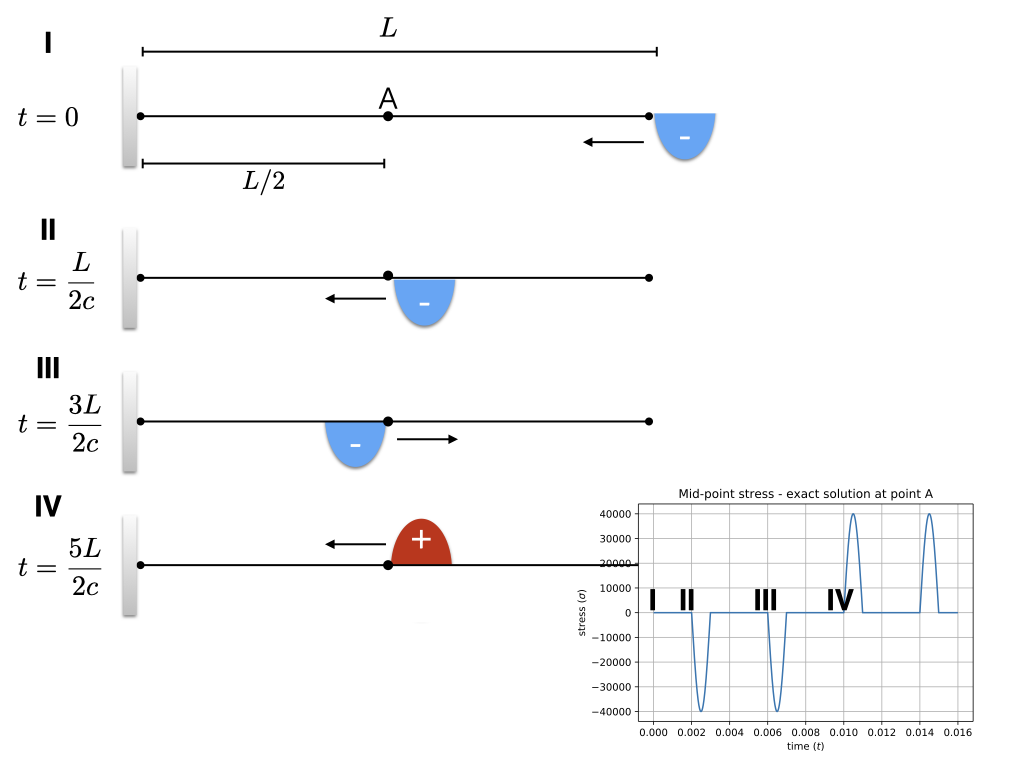

More information on saving and loading data files is provided below.

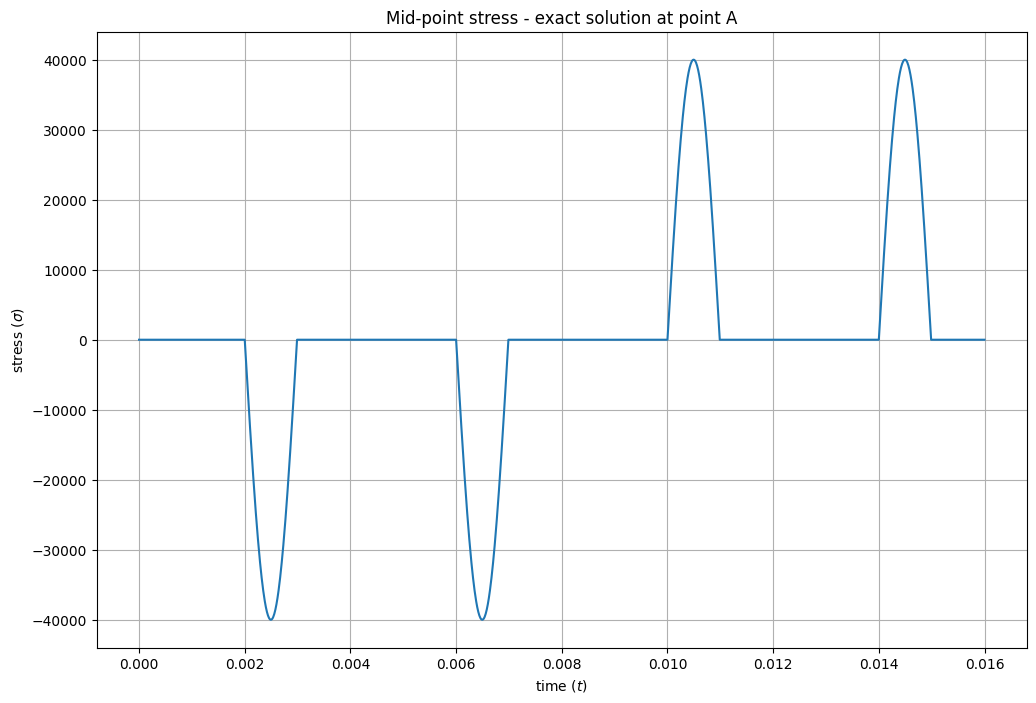

In [4]:
T = 0.016
A_bar = -4e4
delta_t_exact = 1e-5
n_timestep_exact = int(T / delta_t_exact)

t_exact = np.linspace(0, T, n_timestep_exact + 1)
stress_exact = np.zeros((n_timestep_exact+1))
peak_steps = 100
peak_stress_dis = A_bar * np.sin(np.linspace(0, np.pi, peak_steps))

t_peak_1_beg = 200
t_peak_1_end = t_peak_1_beg + peak_steps
stress_exact[t_peak_1_beg:t_peak_1_end] = peak_stress_dis

t_peak_2_beg = 600
t_peak_2_end = t_peak_2_beg + peak_steps
stress_exact[t_peak_2_beg:t_peak_2_end] = peak_stress_dis

t_peak_3_beg = 1000
t_peak_3_end = t_peak_3_beg + peak_steps
stress_exact[t_peak_3_beg:t_peak_3_end] = -peak_stress_dis

t_peak_4_beg = 1400
t_peak_4_end = t_peak_4_beg + peak_steps
stress_exact[t_peak_4_beg:t_peak_4_end] = -peak_stress_dis

# selected output data is stored to a file with the name given below
# use this to save the results from the simulations with different parameters
outfile = local_path + '\\data\\data_exact'
# here we save the stress data for the middle element.
# the data is saved to the file stored in the variable name `outfile`
np.savez(outfile, t_exact, stress_exact)

plt.figure(figsize = (12, 8))
plt.plot(t_exact,stress_exact)
plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.grid()
plt.title('Mid-point stress - exact solution at point A')
plt.show()

In [5]:
outfile

'C:\\Users\\mi6or\\JUPYTER\\JUPYTER\\STRUCTURAL_ANALYSIS_5\\data\\data_exact'

#Saving and loading data

The following code block shows you how to load saved data and to compare it to the exact solution. The files `data_LA.npz` and `data_FG.npz` contain the results of the simulations you have already performed and saved.

<pre><code>
npzfile_exact = np.load('data_exact.npz')
t_exact = npzfile_exact['arr_0']
stress_exact = npzfile_exact['arr_1']

npzfile_LA = np.load('data_LA.npz')
t_LA = npzfile_LA['arr_0']
stress_LA = npzfile_LA['arr_1']

npzfile_FG = np.load('data_FG.npz')
t_FG = npzfile_FG['arr_0']
stress_FG = npzfile_FG['arr_1']

line1, = plt.plot(t_exact,stress_exact, label = 'exact')
line2, = plt.plot(t_LA,stress_LA, label = 'LA')
line3, = plt.plot(t_FG,stress_FG, label = 'FG')
plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress')
plt.legend(handles=[line1, line2, line3])
plt.grid()
plt.show()
</code></pre>

# Main function definitions

In [6]:
# definte the stiffness matrix associated with a single element from the finite element mesh
def get_Ke(Ae, Ee, le):
    return  (Ae * Ee / le) * np.array([[1., -1.], [-1., 1.]])

#
def get_Me(Ae, rho_tilde_e, le, consistent):
    if consistent == True:
        return (Ae * rho_tilde_e * le / 6.) * np.array([[2., 1.], [1., 2.]])
    return (Ae * rho_tilde_e * le / 2.) * np.array([[1., 0.], [0., 1.]])

def get_dof_index(e):
    return [e, e + 1]   

def get_delta_t_crit(le, gamma, beta, consistent, c):
    term_A = gamma / 2. - beta
    if term_A < np.finfo(float).eps:
        return 1.0
    Omega_crit = term_A ** (-0.5)
    if consistent == True:
        omega_max = 2*np.sqrt(3)*c/le
    else:
        omega_max = 2*c/le
    return Omega_crit / omega_max 

def get_c_longitudal_bar_wave_velocity(G, p_bulk_density):
    return math.sqrt(E / p_bulk_density)

def get_c_shear_bar_wave_velocity(G, p_bulk_density):
    return math.sqrt(G / p_bulk_density)

# def get_file_saved_for_a_specific_solution(integration_scheme, ):
    
#     integration_scheme = {
#                          'AA': [1/4, 1/2],
#                          'LA': [1/6, 1/2],
#                          'FG': [1/12, 1/2],
#                          'CD': [10, 1/2]
#                          }

#     print(f"LA Integration Scheme Information")
#     print('----------------------------------------------')
#     print('beta = %2.3f, \tgamma = %2.3f' %(beta, gamma))
#     print('c = %2.3f' %c)
#     print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit, delta_t))
#     print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
#     print('----------------------------------------------')

#     n_t_steps = int(np.ceil(T / delta_t));    # number of time step

#     # initialise the time domain, K and M
#     t = np.linspace(0, T, n_t_steps)
#     K = np.zeros((n_dof, n_dof))
#     M = np.zeros((n_dof, n_dof))

#     # assemble K and M
#     for ee in range(n_el):
#       dof_index = get_dof_index(ee)

#       K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
#       M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

#     # damping matrix
#     C = np.zeros((n_dof, n_dof))

#     # assemble the system matrix A
#     A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

#     # define the free dofs
#     free_dof = np.arange(1,n_dof)

#     # initial conditions
#     d = np.zeros((n_dof, 1))
#     v = np.zeros((n_dof, 1))
#     F = np.zeros((n_dof, 1))

#     # compute the initial acceleration
#     a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

#     # store the history data 
#     # rows -> each node 
#     # columns -> each time step including initial at 0
#     d_his = np.zeros((n_dof, n_t_steps))
#     v_his = np.zeros((n_dof, n_t_steps))
#     a_his = np.zeros((n_dof, n_t_steps))
#     d_his[:,0] = d[:,0]
#     v_his[:,0] = v[:,0]
#     a_his[:,0] = a[:,0]

#     # loop over the time domain and solve the problem at each step
#     for n in range(1,n_t_steps):
#       if n % 200 == 0:
#         print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

#       # data at beginning of the time-step n
#       a_n = a
#       v_n = v
#       d_n = d

#       # applied loading
#       t_current = n * delta_t # current time
#       if t_current<0.001:
#         F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
#       else:
#         F[-1]=0.

#       # define predictors
#       d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
#       v_tilde = v_n + (1 - gamma) * delta_t * a_n

#       # assemble the right-hand side from the known data
#       R = F - C.dot(v_tilde) - K.dot(d_tilde)

#       # impose essential boundary condition and solve A a = RHS
#       A_free = A_matrix[np.ix_(free_dof, free_dof)]
#       R_free = R[np.ix_(free_dof)]

#       # solve for the accelerations at the free nodes
#       a_free = np.linalg.solve(A_free, R_free) 
#       a = np.zeros((n_dof, 1))
#       a[1:] = a_free

#       # update displacement and vecloity predictors using the acceleration
#       d = d_tilde + (beta * delta_t**2) * a
#       v = v_tilde + (gamma * delta_t) * a

#       # store solutions
#       d_his[:,n] = d[:,0]
#       v_his[:,n] = v[:,0]
#       a_his[:,n] = a[:,0]

#     # post-processing
#     mid_node = int(np.ceil(n_dof / 2))  # mid node

#     # compute the stress in each element
#     # assuming constant E
#     stress = (E / le) * np.diff(d_his, axis=0)

#     # here we save the stress data for the middle element
#     np.savez(outfile, t, stress[mid_node,:])

# The finite element code
You are provided with the working finite element code shown below.

LA Integration Scheme Information
----------------------------------------------
beta = 0.167, 	gamma = 0.500
c = 5000.000
delta_t_crit =  2.000E-05, 	delta_t =  6.000E-06
delta_t / delta_t_crit = 0.300
----------------------------------------------
Time step:  200  , Total time:  0.0012000000000000001  of  0.016
Time step:  400  , Total time:  0.0024000000000000002  of  0.016
Time step:  600  , Total time:  0.0036  of  0.016
Time step:  800  , Total time:  0.0048000000000000004  of  0.016
Time step:  1000  , Total time:  0.006  of  0.016
Time step:  1200  , Total time:  0.0072  of  0.016
Time step:  1400  , Total time:  0.0084  of  0.016
Time step:  1600  , Total time:  0.009600000000000001  of  0.016
Time step:  1800  , Total time:  0.0108  of  0.016
Time step:  2000  , Total time:  0.012  of  0.016
Time step:  2200  , Total time:  0.0132  of  0.016
Time step:  2400  , Total time:  0.0144  of  0.016
Time step:  2600  , Total time:  0.015600000000000001  of  0.016


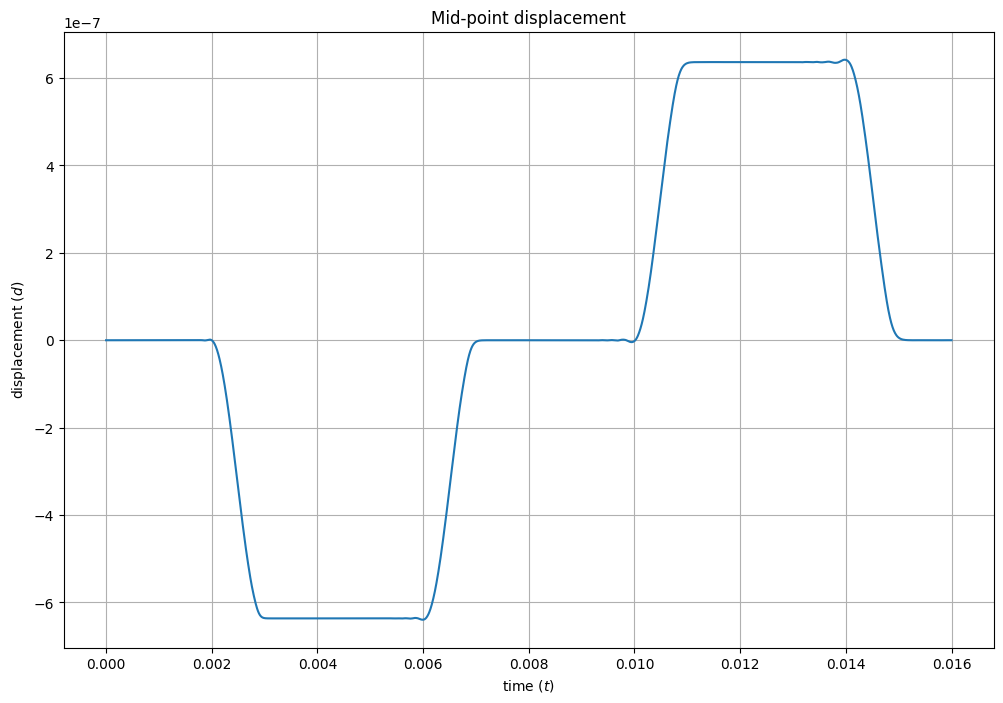

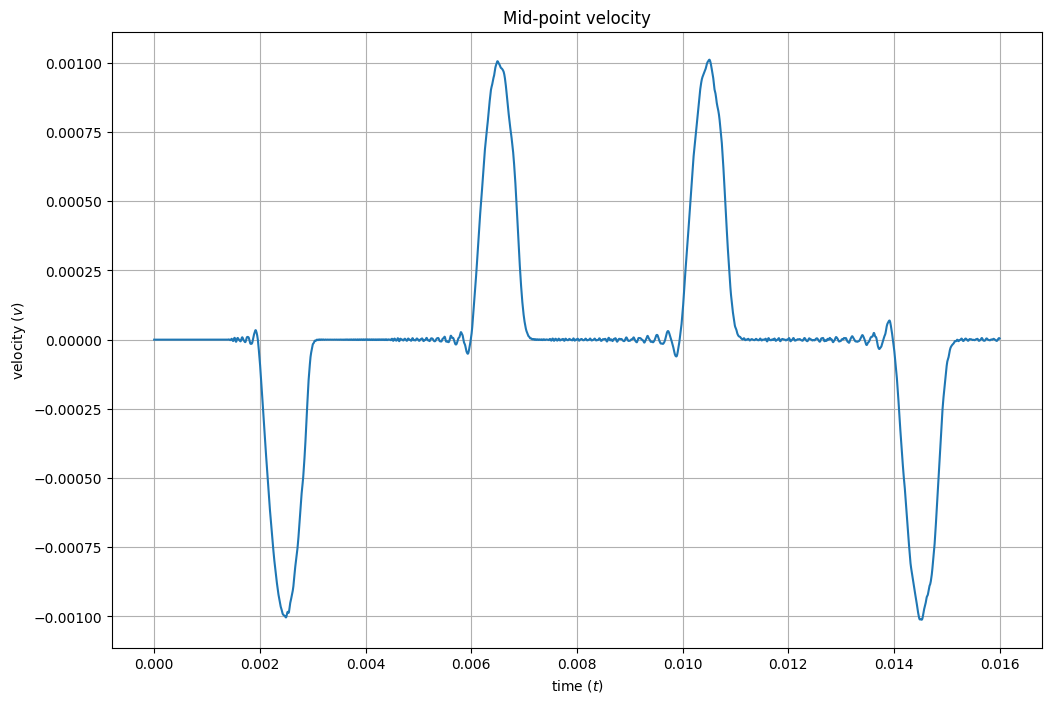

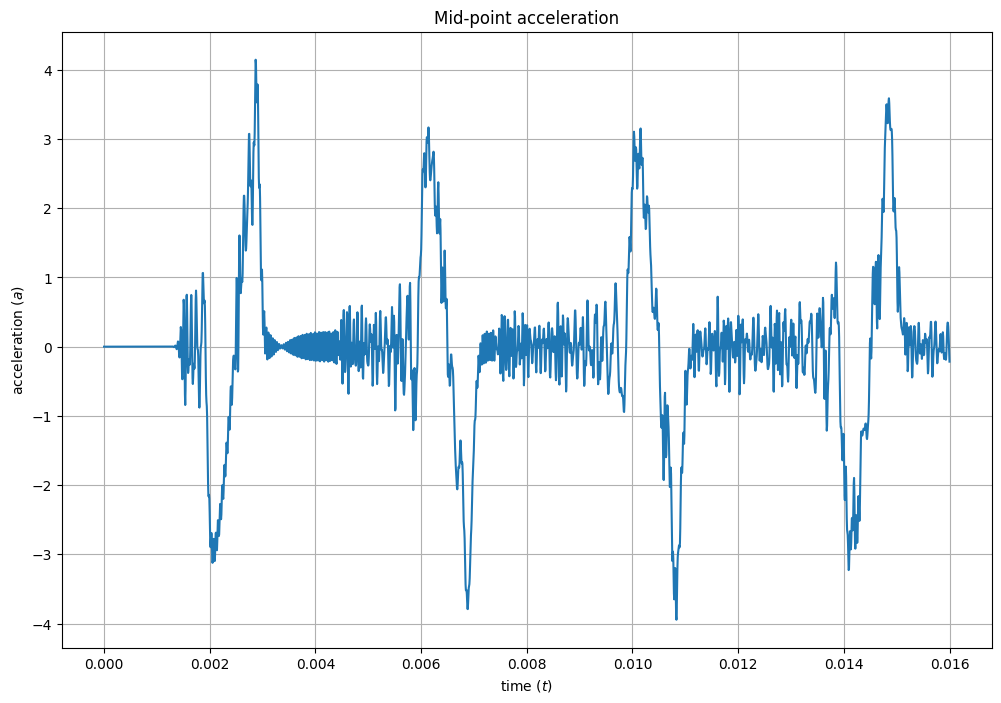

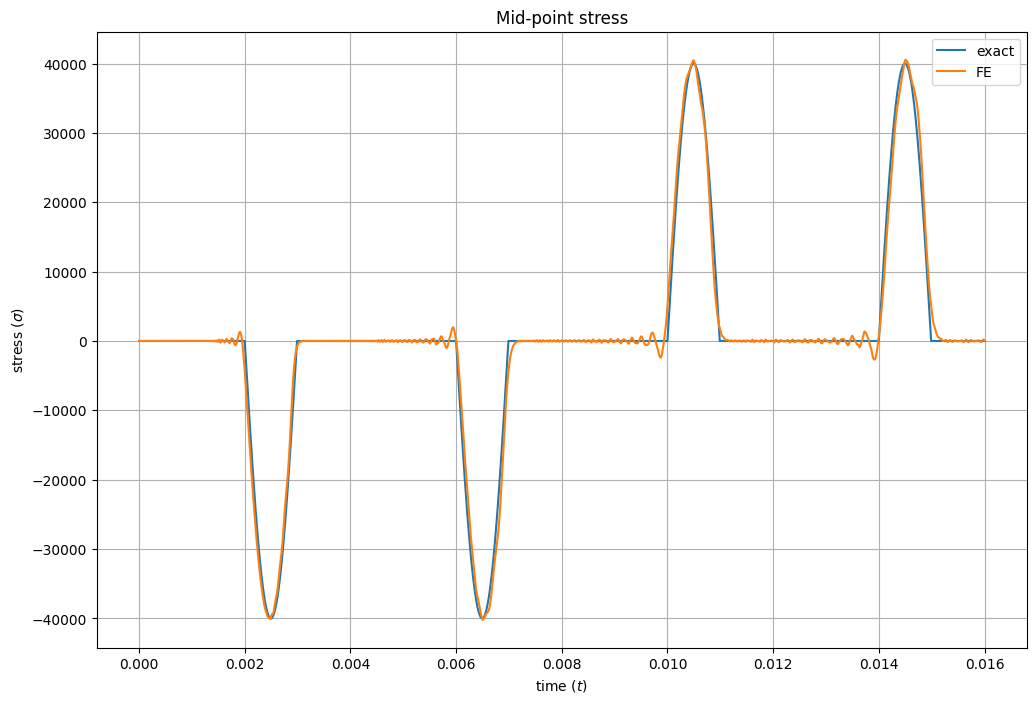

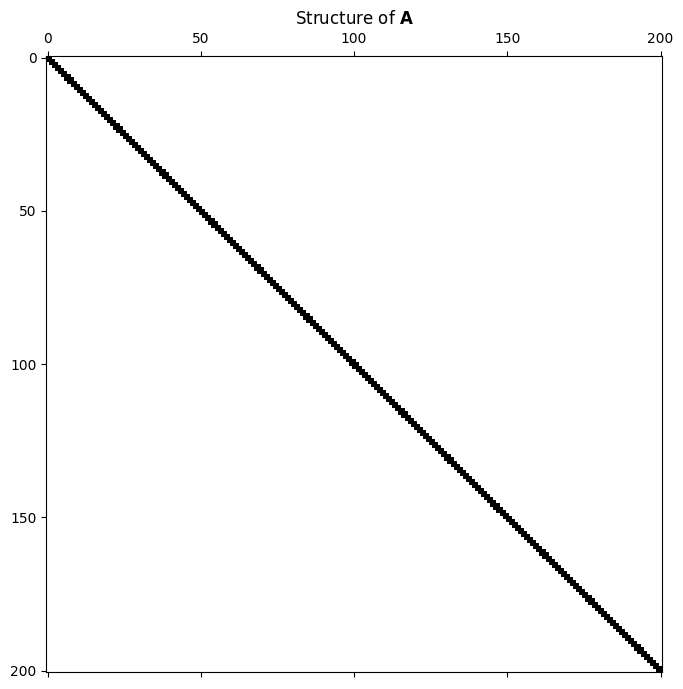

In [7]:
# material properties
E = 200e9         # Young's modulus [N/m**2]
rho_tilde = 8000  # density [kg/m**3]

multimat = False  # flag for multimaterials 

# domain data
L = 20.       # length of the domain [m]
Ae = 100e-6   # cross sectional area [m**2]

# loading 
A_bar = -4e4  # applied traction [N/m**2]

# mesh data
n_el = 200                # number of elements
n_np = n_el + 1           # number of nodal points
n_dof = n_np              # number of degrees of freedom
x = np.linspace(0, L, n_np) # x-coordinates of the nodes
le = L / n_el             # length of an element

# time integration data
# see note for further details
# Newmark method parameters
#  Scheme |    beta    |   gamma  |
#   AA*   |    1/4     |   1/2    |
#   LA    |    1/6     |   1/2    |
#   FG    |    1/12    |   1/2    |
#   CD    |    0       |   1/2    |
# note the AA scheme is unconditionally stable.
# Newmark parameters
beta = 1./6
gamma = 1./2
consistent = True   # use a consistent mass matrix

T = 0.016   # total time
c = np.sqrt(E/ rho_tilde)  # wave speed

# compute the critical time-step
# note: uncondionally stable AA scheme will return 1.0
delta_t_crit = get_delta_t_crit(le, gamma, beta , consistent, c)


# actual times-step used is a factor of the critical time-step
reduction_factor = 0.3
delta_t = reduction_factor * delta_t_crit

# selected output data is stored to a file with the name given below
# use this to save the results from the different runs
# change the name to match the data you want to store
outfile = local_path + '\\data\\data_LA_0_3_mass_con.npz'

print(f"LA Integration Scheme Information")
print('----------------------------------------------')
print('beta = %2.3f, \tgamma = %2.3f' %(beta, gamma))
print('c = %2.3f' %c)
print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit, delta_t))
print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
print('----------------------------------------------')

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
    dof_index = get_dof_index(ee)

    K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
    M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
    if n % 200 == 0:
        print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

    # data at beginning of the time-step n
    a_n = a
    v_n = v
    d_n = d

    # applied loading
    t_current = n * delta_t # current time
    
    if t_current<0.001:
        F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
    else:
        F[-1]=0.

    # define predictors
    d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
    v_tilde = v_n + (1 - gamma) * delta_t * a_n

    # assemble the right-hand side from the known data
    R = F - C.dot(v_tilde) - K.dot(d_tilde)

    # impose essential boundary condition and solve A a = RHS
    A_free = A_matrix[np.ix_(free_dof, free_dof)]
    R_free = R[np.ix_(free_dof)]

    # solve for the accelerations at the free nodes
    a_free = np.linalg.solve(A_free, R_free) 
    a = np.zeros((n_dof, 1))
    a[1:] = a_free

    # update displacement and vecloity predictors using the acceleration
    d = d_tilde + (beta * delta_t**2) * a
    v = v_tilde + (gamma * delta_t) * a

    # store solutions
    d_his[:,n] = d[:,0]
    v_his[:,n] = v[:,0]
    a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

plt.figure(figsize = (12, 8))
plt.plot(t,d_his[mid_node,:])
plt.xlabel('time ($t$)')
plt.ylabel('displacement ($d$)')
plt.title('Mid-point displacement')
plt.grid()
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(t,v_his[mid_node,:])
plt.xlabel('time ($t$)')
plt.ylabel('velocity ($v$)')
plt.title('Mid-point velocity')
plt.grid()
plt.show()

plt.figure(figsize = (12, 8))
plt.plot(t,a_his[mid_node,:])
plt.xlabel('time ($t$)')
plt.ylabel('acceleration ($a$)')
plt.title('Mid-point acceleration')
plt.grid()
plt.show()

# plot the exact stress versus the FE predicted stress
plt.figure(figsize = (12, 8))
line1, = plt.plot(t_exact,stress_exact, label = 'exact')
line2, = plt.plot(t,stress[mid_node,:], label = 'FE')
plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress')
plt.legend(handles=[line1, line2])
plt.grid()
plt.show()

plt.figure(figsize = (12, 8))
plt.spy(A_matrix)
plt.title('Structure of $\mathbf{A}$')
plt.show()   

# Question 1
* What is the bar wave velocity $c$?

The bar wave velocity c is the speed of propagation of a wave across the bar. There are two types of waves that can be propagated in a bar under dynamic loading: longitudinal waves and transverse waves. Longitudinal waves propagate parallel to the direction of the wave motion, while transverse waves propagate perpendicular to the direction of the wave motion.

The propagation velocity of longitudinal waves in a bar can be calculated using the following formula:
**v = √(E/ρ)**, where ρ is the bulk density of the bar.

The propagation velocity of transverse waves in a bar can be calculated using the following formula:
**v = √(G/ρ)**, where ρ is the bulk density of the bar.
<br></br>

* How long will it take for a disturbance applied at the free end to travel the length of the bar?
<br></br>

**t = 0.004s**
<br></br>

* How is this behavior different to that of the linear elastic problem (i.e. with no inertial term present) considered previously in this course?
<br></br>

The time dependent behavior analysis includes considerations regarding the inertia of the system, in the form of an inertial term. The time dependent analysis assumes 1D linear (linearly - elastic) elements and uses the Stiffness matrix derived from basic 1D FEM. However the difference comes from the inertial term **ma** (mass x acceleration), which in contrast to linear elastic problems, takes into account the effects of time-varying loads, acceleration, and velocity on the structure. The inertial forces can cause the structure to vibrate, oscillate or undergo transient responses, which are not present in the static problem. The solution to the time-dependent problem requires the use of time-stepping methods and algorithms to solve the dynamic equations of motion, those equations are solved numerically, in this particular case using Newmark Integration Schemes.

In [10]:
# the propagation velocity of the bar wave in the longitudal direction is the function of the Young's modulus of the bar divided and the bulk density of the bar rho [m/s]

c = get_c_longitudal_bar_wave_velocity(E, rho_tilde)

# the time required for the longitudal wave to travel the entire length of the bar is equal to the lenght L divided by the velocity c
time_for_wave_to_travel = L / c

print('----------------------------------------------')
print(f"The propagation velocity of the longitudal bar wave is equal to: c^2 = E/p: c = {c} [m/s].")
print('----------------------------------------------')
print()
print('----------------------------------------------')
print(f"The time required for the wave to propage through the entire length of the bar is equal to: t = {time_for_wave_to_travel} [s].")
print('----------------------------------------------')

----------------------------------------------
The propagation velocity of the longitudal bar wave is equal to: c^2 = E/p: c = 5000.0 [m/s].
----------------------------------------------

----------------------------------------------
The time required for the wave to propage through the entire length of the bar is equal to: t = 0.004 [s].
----------------------------------------------


# Question 2
Assume a consistent mass matrix. Use the critical time-step size as computed by the central difference method.

For  ratios of $\Delta t / \Delta t_\text{c} = 0.1,~0.9,~0.99,~1,~1.1,~ 2$, compare the stress response at point A for the average acceleration and central difference schemes.
Also show the exact solution in your results.

Explain the results with reference to the theory discussed in the lectures.

In the cases where the reduction factor is less than or equal to 1 we expect both integration schemes to work properly and to provide similar results, which is the case for the first 4 graphs in the solution for Question 2. However in the cases where the reduction factor is larger than 1, or the delta_t is larger than the critical delta_t we have unstable solution (stemming from the conditionally stable nature of the Central Difference integration scheme. The solution for Average Acceleration will always be stable, meaning that one potential remedy for the algorithm will be for **Conditionally Stable Schemes** to default to the critical delta_t when the value of delta_t_actual exceeds the threshold. This potential solution will of course have some consistency issues, but will ensure that the code will not terminate prematurely and it will at least produce some results with relevant physical meaning. 

<br></br>
Another important thing to note here is the fact that the smaller delta_t gets, meaning approaching zero in the limit, the accuracy of the solution will improve for both schemes. Of course making delta_t infinitely small is impossible and reducing it below certain values will be computationally very expensive. Reaching a balance of accuracy and computational space, and time, defined by the limiting behavior of a function when the argument tends towards a particular value or infinity is an important aspect. In figure 1 where the **reduction factor = 0.1** the solution is **Very Accurate (Close to the exact solution)** for both integration schemes. Of course hand waving a specific label such as **very accurate** has its own complication and consistency. However, there are many different measurements to assess the accuracy of the solution in terms of the orders of magnitude that are important to the particular engineering application and are an important consideration when assessing the viability of the design solution.


AA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.155E-06
delta_t / delta_t_crit = 0.100
----------------------------------------------

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.155E-06
delta_t / delta_t_crit = 0.100
----------------------------------------------
Time step:  200  , Total time:  0.00023094010767585037  of  0.016
Time step:  400  , Total time:  0.00046188021535170074  of  0.016
Time step:  600  , Total time:  0.000692820323027551  of  0.016
Time step:  800  , Total time:  0.0009237604307034015  of  0.016
Time step:  1000  , Total time:  0.0011547005383792518  of  0.016
Time step:  1200  , Total time:  0.001385640646055102  of  0.016
Time step:  1400  , Total time:  0.0016165807537309525  of  0.016
Time step:  1600  , Total time:  0.001847

Time step:  10200  , Total time:  0.011777945491468367  of  0.016
Time step:  10400  , Total time:  0.012008885599144219  of  0.016
Time step:  10600  , Total time:  0.012239825706820069  of  0.016
Time step:  10800  , Total time:  0.012470765814495919  of  0.016
Time step:  11000  , Total time:  0.01270170592217177  of  0.016
Time step:  11200  , Total time:  0.01293264602984762  of  0.016
Time step:  11400  , Total time:  0.01316358613752347  of  0.016
Time step:  11600  , Total time:  0.013394526245199321  of  0.016
Time step:  11800  , Total time:  0.013625466352875171  of  0.016
Time step:  12000  , Total time:  0.01385640646055102  of  0.016
Time step:  12200  , Total time:  0.014087346568226872  of  0.016
Time step:  12400  , Total time:  0.014318286675902722  of  0.016
Time step:  12600  , Total time:  0.014549226783578572  of  0.016
Time step:  12800  , Total time:  0.014780166891254424  of  0.016
Time step:  13000  , Total time:  0.015011106998930273  of  0.016
Time step:  13

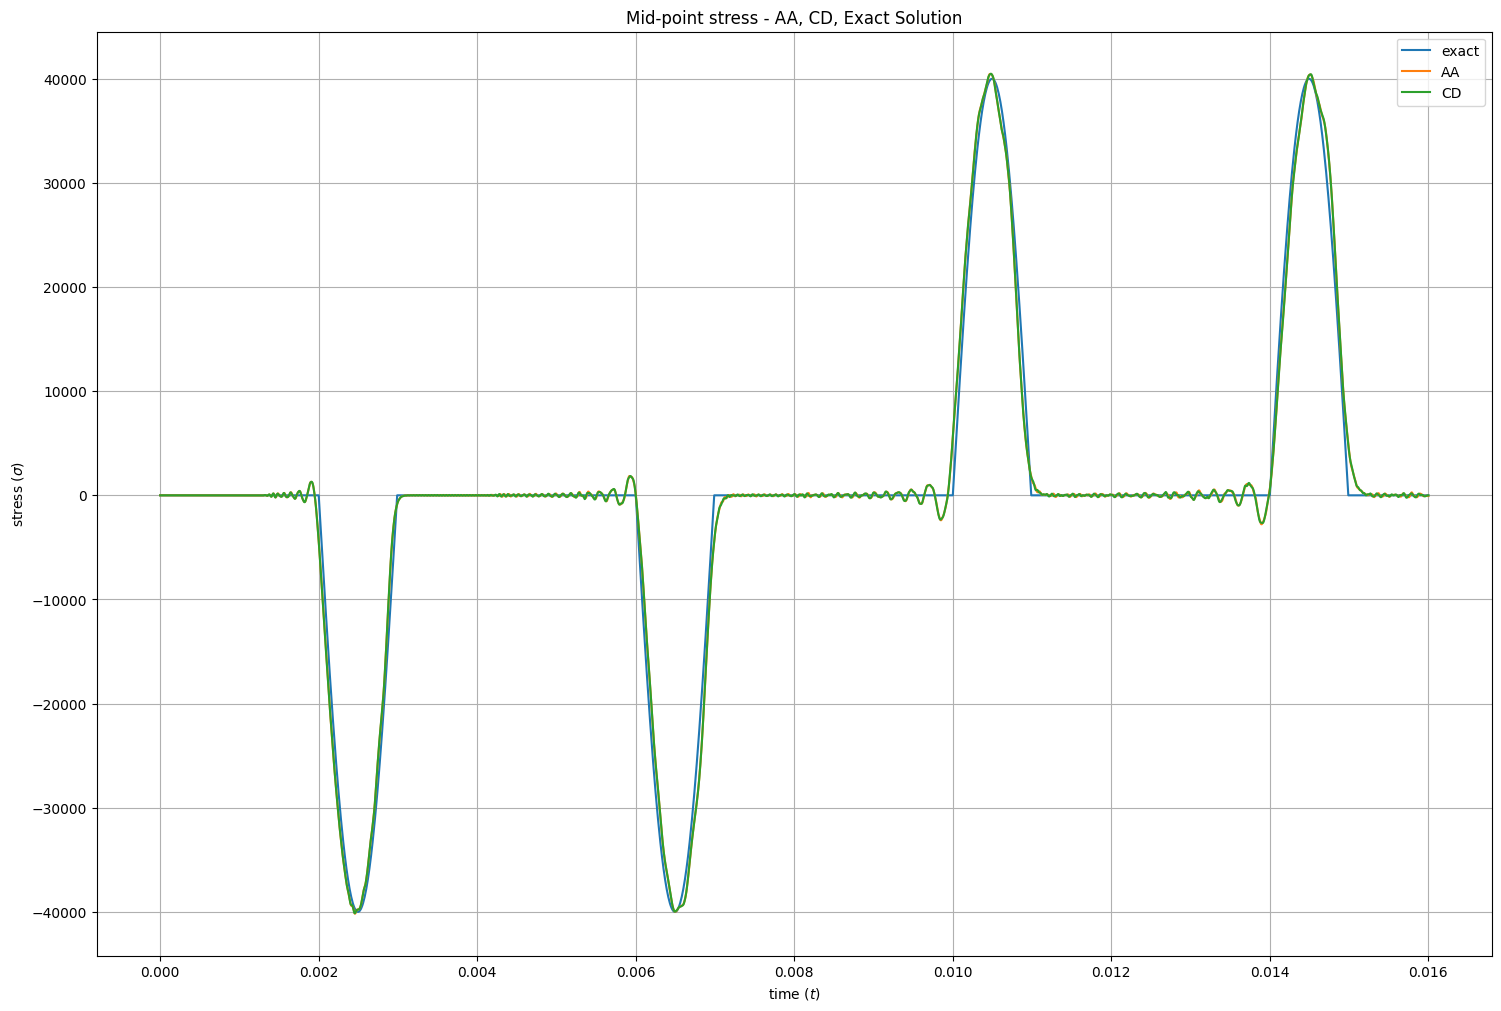

AA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.039E-05
delta_t / delta_t_crit = 0.900
----------------------------------------------

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.039E-05
delta_t / delta_t_crit = 0.900
----------------------------------------------
Time step:  200  , Total time:  0.002078460969082653  of  0.016
Time step:  400  , Total time:  0.004156921938165306  of  0.016
Time step:  600  , Total time:  0.006235382907247959  of  0.016
Time step:  800  , Total time:  0.008313843876330612  of  0.016
Time step:  1000  , Total time:  0.010392304845413265  of  0.016
Time step:  1200  , Total time:  0.012470765814495919  of  0.016
Time step:  1400  , Total time:  0.014549226783578572  of  0.016
Time step:  200  , Total time:  0.00207846096908

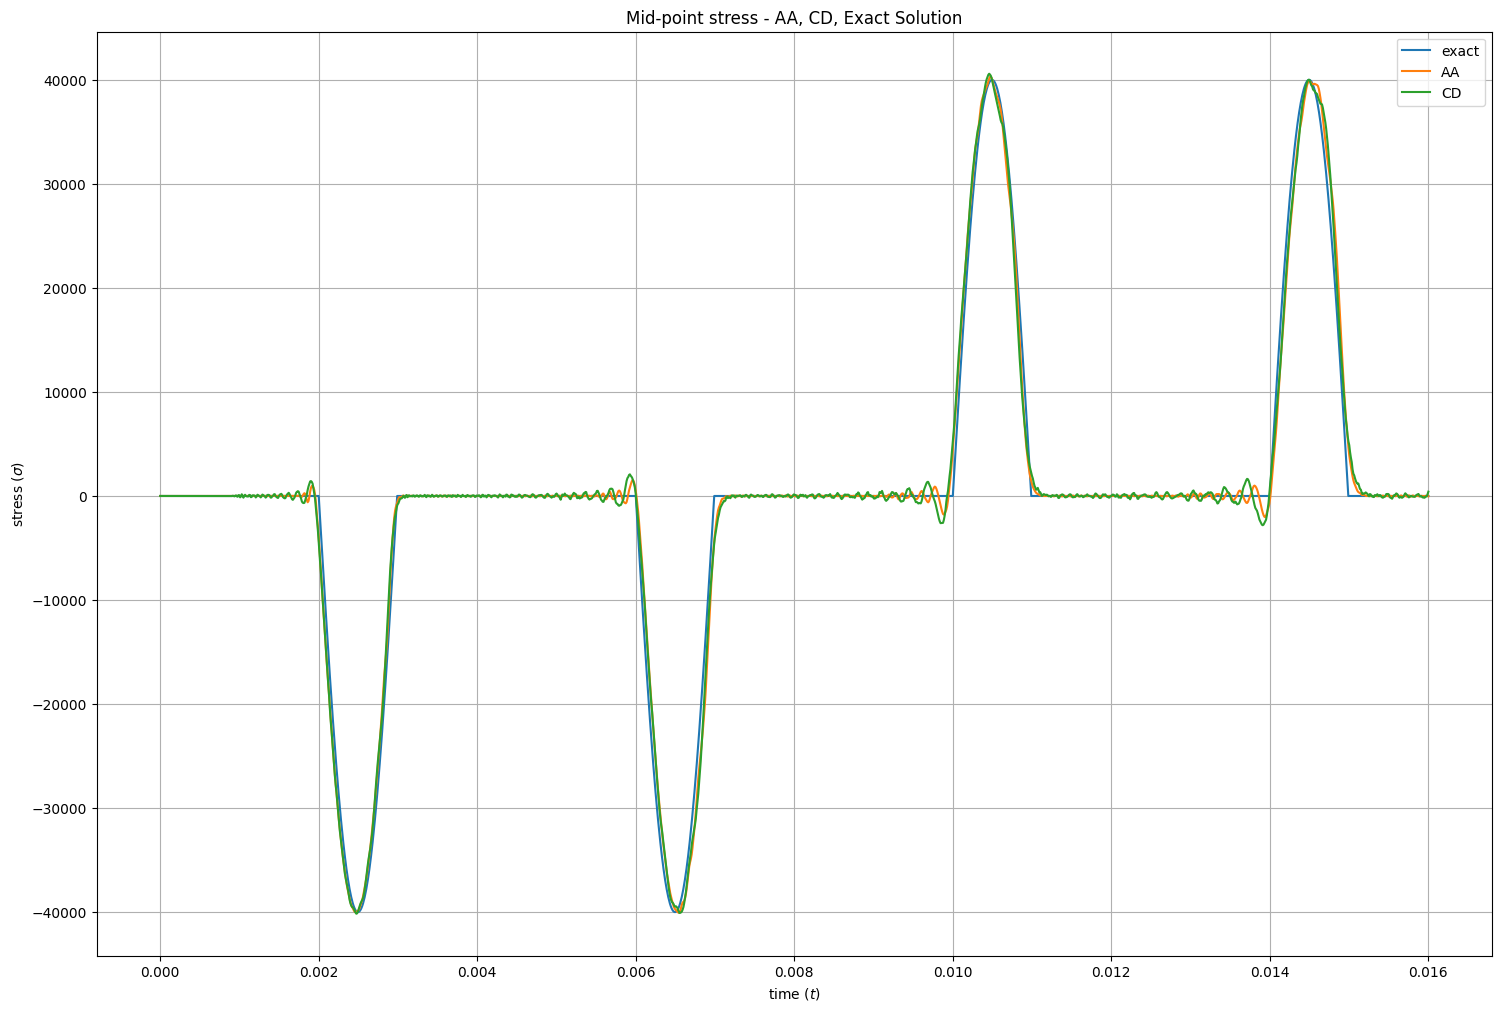

AA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.143E-05
delta_t / delta_t_crit = 0.990
----------------------------------------------

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.143E-05
delta_t / delta_t_crit = 0.990
----------------------------------------------
Time step:  200  , Total time:  0.0022863070659909185  of  0.016
Time step:  400  , Total time:  0.004572614131981837  of  0.016
Time step:  600  , Total time:  0.006858921197972756  of  0.016
Time step:  800  , Total time:  0.009145228263963674  of  0.016
Time step:  1000  , Total time:  0.011431535329954593  of  0.016
Time step:  1200  , Total time:  0.013717842395945512  of  0.016
Time step:  200  , Total time:  0.0022863070659909185  of  0.016
Time step:  400  , Total time:  0.0045726141319

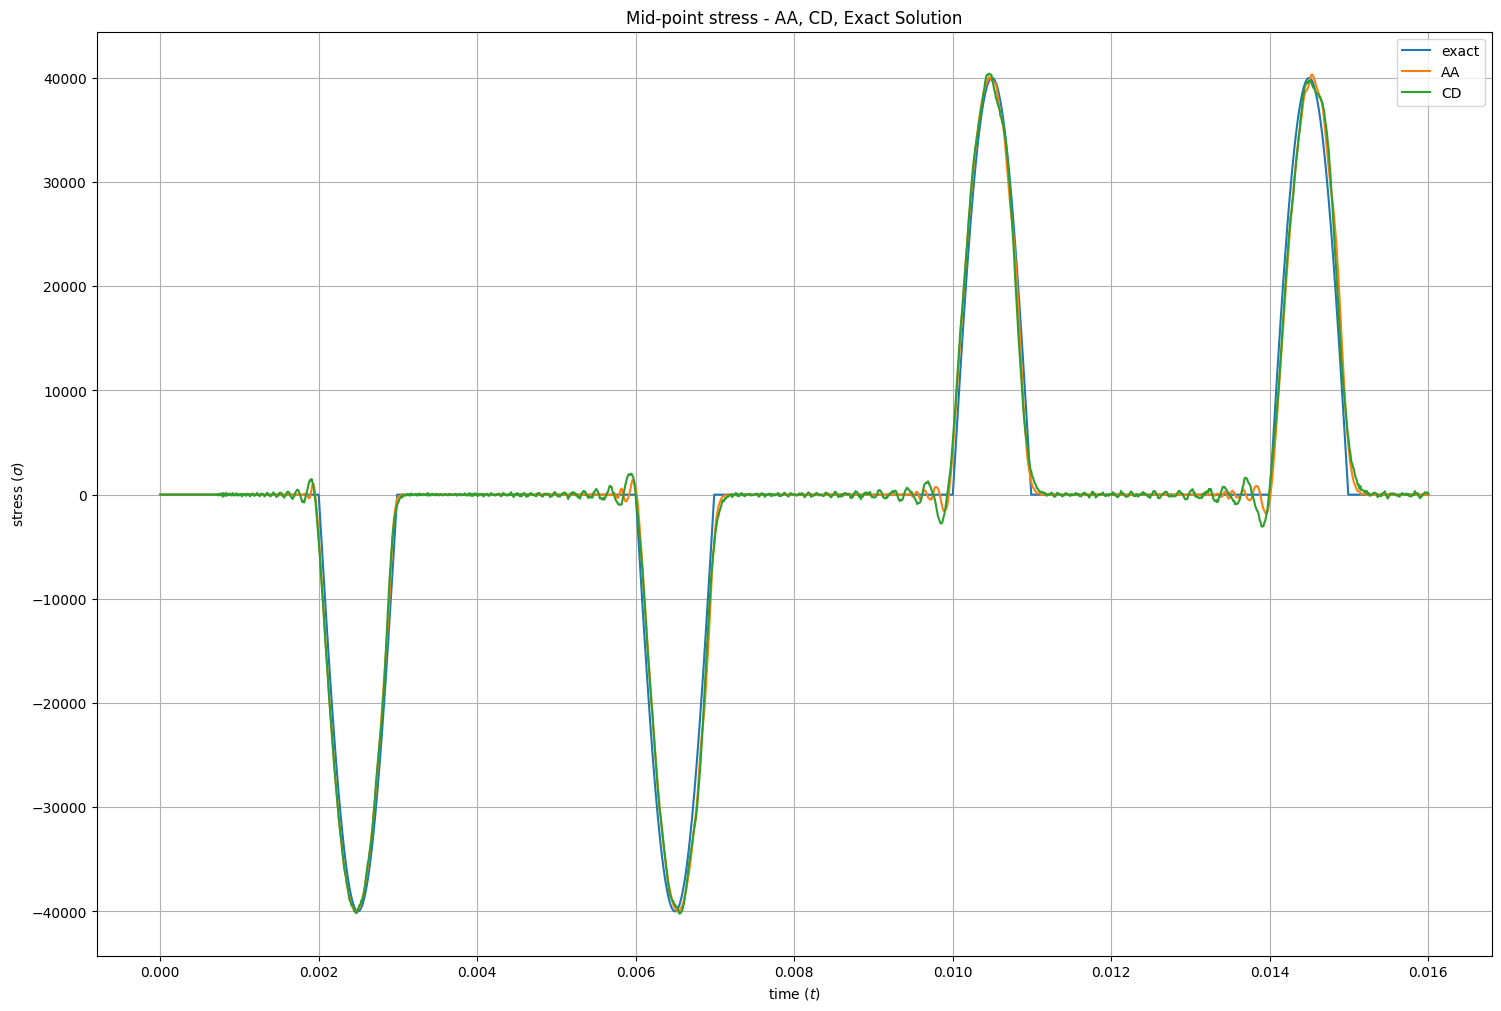

AA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.155E-05
delta_t / delta_t_crit = 1.000
----------------------------------------------

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.155E-05
delta_t / delta_t_crit = 1.000
----------------------------------------------
Time step:  200  , Total time:  0.0023094010767585036  of  0.016
Time step:  400  , Total time:  0.004618802153517007  of  0.016
Time step:  600  , Total time:  0.00692820323027551  of  0.016
Time step:  800  , Total time:  0.009237604307034014  of  0.016
Time step:  1000  , Total time:  0.011547005383792518  of  0.016
Time step:  1200  , Total time:  0.01385640646055102  of  0.016
Time step:  200  , Total time:  0.0023094010767585036  of  0.016
Time step:  400  , Total time:  0.004618802153517

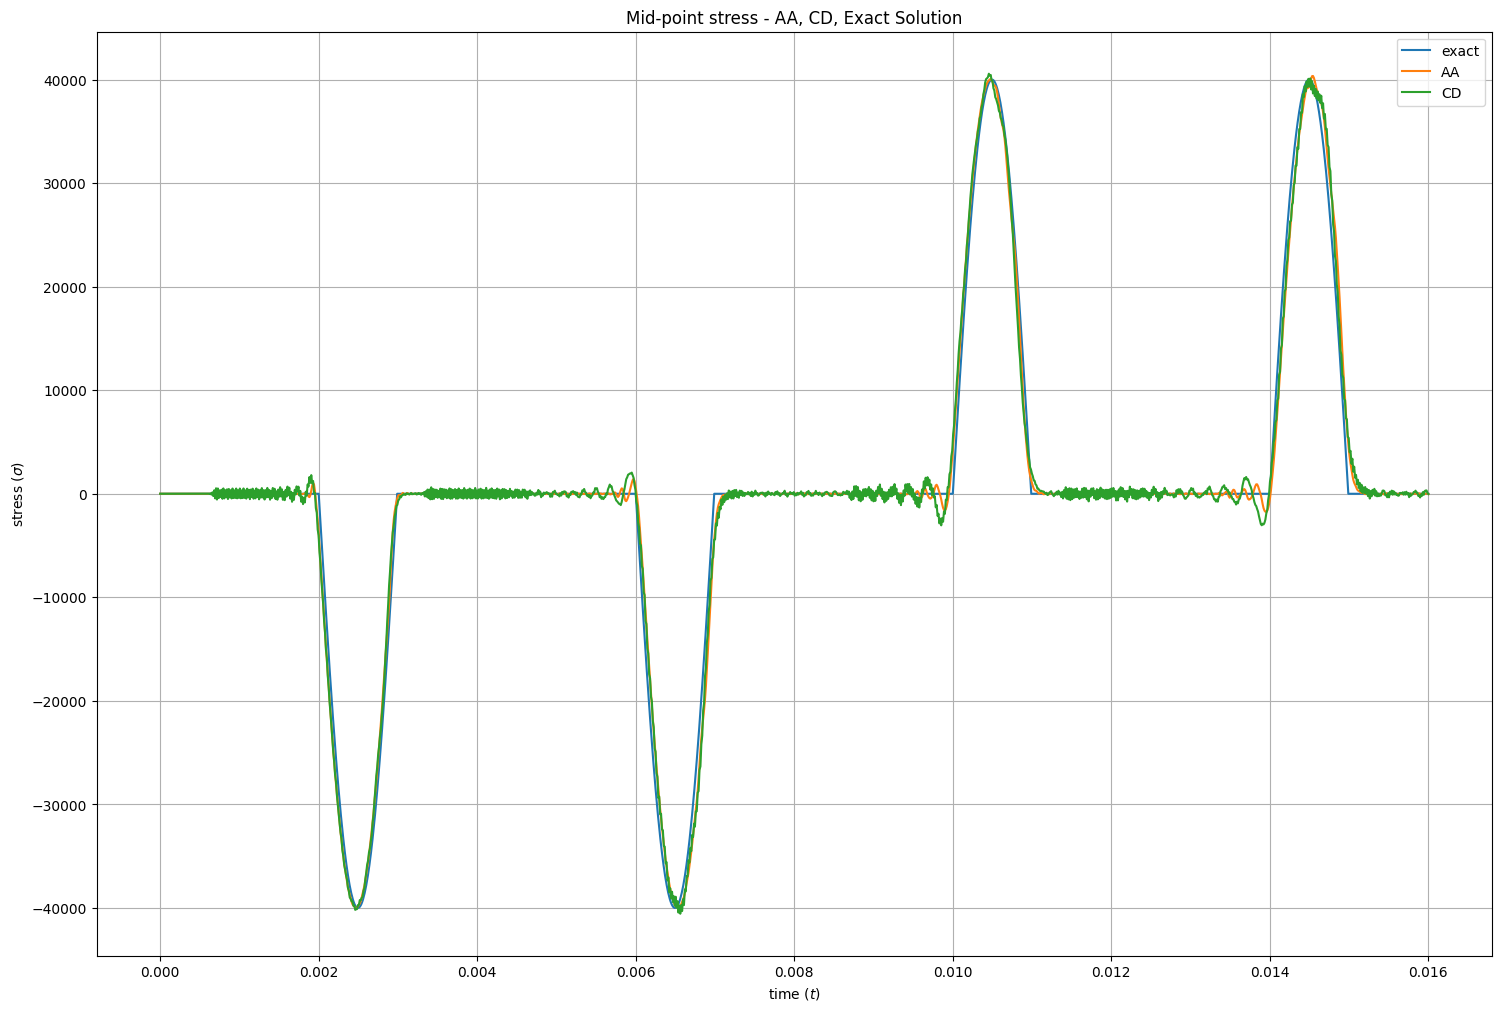

AA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.270E-05
delta_t / delta_t_crit = 1.100
----------------------------------------------

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  1.270E-05
delta_t / delta_t_crit = 1.100
----------------------------------------------
Time step:  200  , Total time:  0.0025403411844343543  of  0.016
Time step:  400  , Total time:  0.005080682368868709  of  0.016
Time step:  600  , Total time:  0.007621023553303062  of  0.016
Time step:  800  , Total time:  0.010161364737737417  of  0.016
Time step:  1000  , Total time:  0.01270170592217177  of  0.016
Time step:  1200  , Total time:  0.015242047106606125  of  0.016
Time step:  200  , Total time:  0.0025403411844343543  of  0.016
Time step:  400  , Total time:  0.00508068236886

C:\Users\mi6or\AppData\Local\Temp\ipykernel_13184\537912497.py:302: RuntimeWarning: invalid value encountered in multiply
  d = d_tilde + (beta * delta_t**2) * a


Time step:  1200  , Total time:  0.015242047106606125  of  0.016


C:\Users\mi6or\AppData\Local\Temp\ipykernel_13184\537912497.py:315: RuntimeWarning: overflow encountered in multiply
  stress = (E / le) * np.diff(d_his, axis=0)
C:\Users\mi6or\AppData\Roaming\Python\Python39\site-packages\matplotlib\ticker.py:2073: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


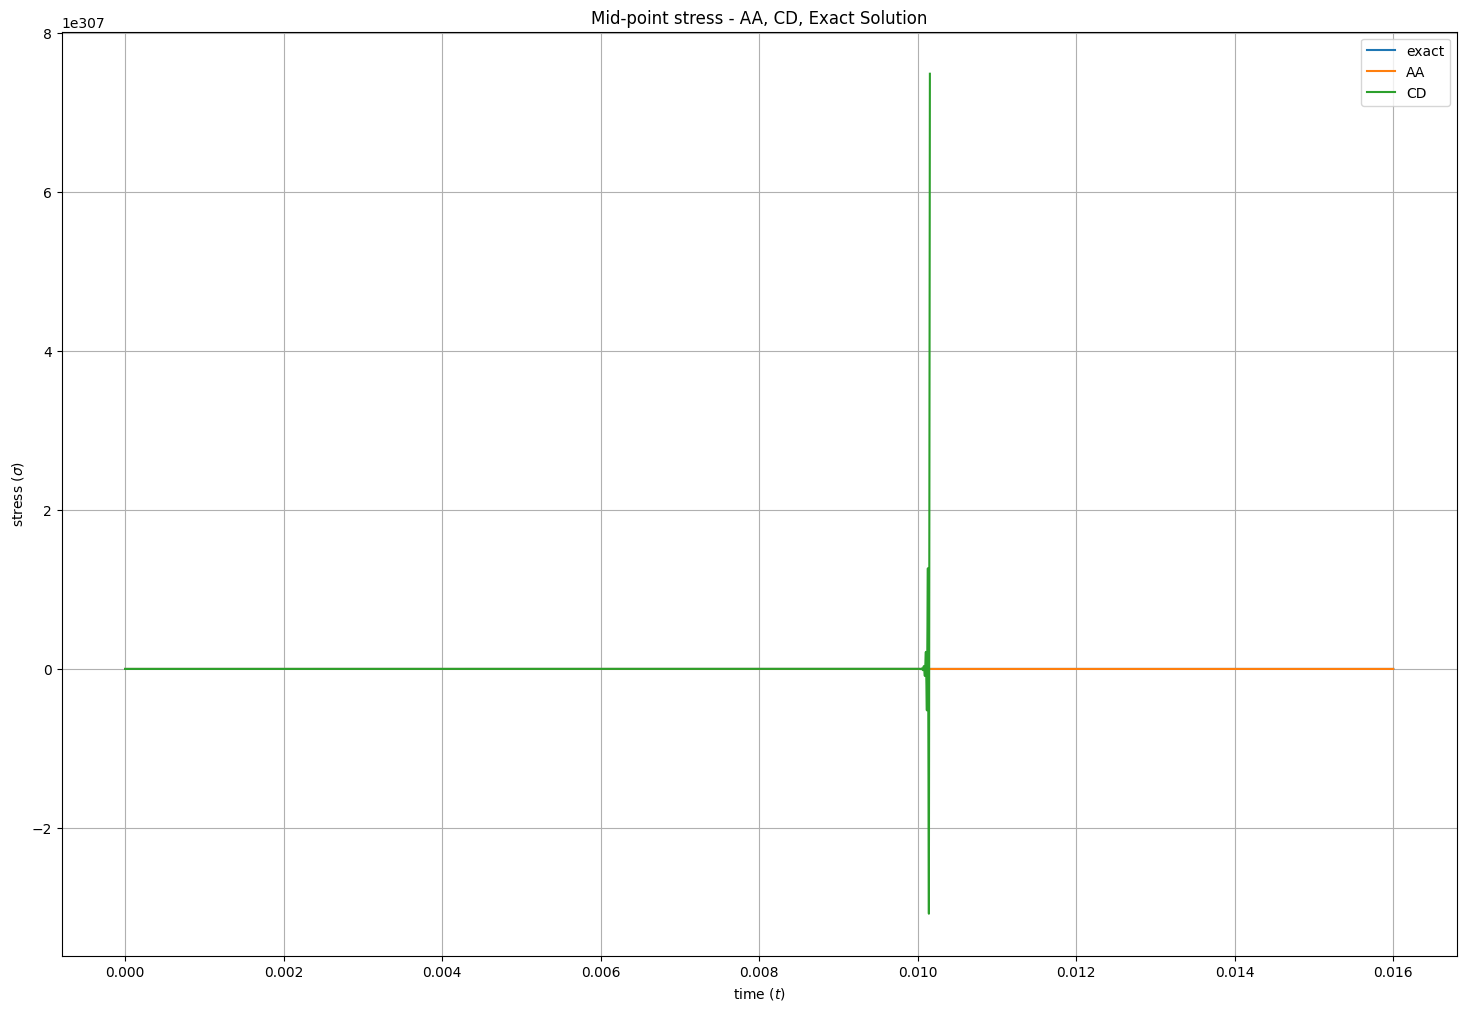

AA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  2.309E-05
delta_t / delta_t_crit = 2.000
----------------------------------------------

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  2.309E-05
delta_t / delta_t_crit = 2.000
----------------------------------------------
Time step:  200  , Total time:  0.004618802153517007  of  0.016
Time step:  400  , Total time:  0.009237604307034014  of  0.016
Time step:  600  , Total time:  0.01385640646055102  of  0.016
Time step:  200  , Total time:  0.004618802153517007  of  0.016
Time step:  400  , Total time:  0.009237604307034014  of  0.016
Time step:  600  , Total time:  0.01385640646055102  of  0.016


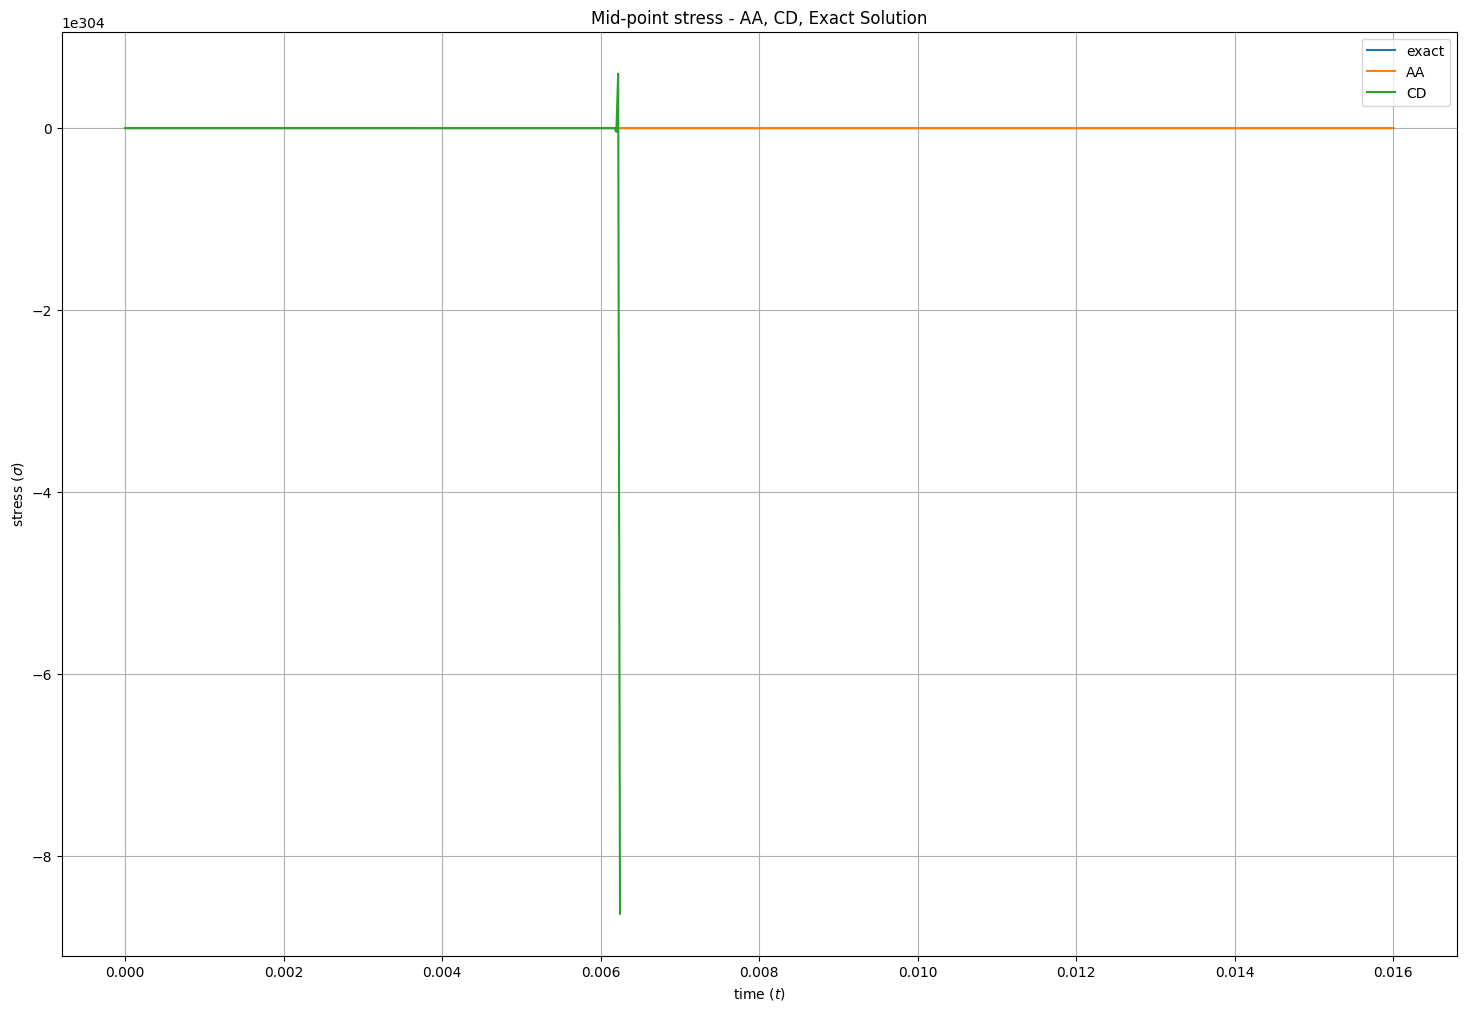

In [11]:
# create a list with all the ratios in the list to compare all of the results. Loop over each possible value of the list
reduction_factor_list = [0.1, 0.9, 0.99, 1, 1.1, 2]


# material properties
E = 200e9         # Young's modulus [N/m**2]
rho_tilde = 8000  # density [kg/m**3]

multimat = False  # flag for multimaterials 

# domain data
L = 20.       # length of the domain [m]
Ae = 100e-6   # cross sectional area [m**2]

# loading 
A_bar = -4e4  # applied traction [N/m**2]

# mesh data
n_el = 200                # number of elements
n_np = n_el + 1           # number of nodal points
n_dof = n_np              # number of degrees of freedom
x = np.linspace(0, L, n_np) # x-coordinates of the nodes
le = L / n_el             # length of an element

# time integration data
# see note for further details
# Newmark method parameters
#  Scheme |    beta    |   gamma  |
#   AA*   |    1/4     |   1/2    |
#   LA    |    1/6     |   1/2    |
#   FG    |    1/12    |   1/2    |
#   CD    |    0       |   1/2    |
# note the AA scheme is unconditionally stable.
# Newmark parameters


# loop over all reduction factor possibilities for the AA and CD schemes, the naming of all of the files is integratio scheme, the question number, followed by the 
# reduction factor included in the name
for reduction_factor in reduction_factor_list:
    
    beta_AA = 1./4
    gamma_AA = 1./2
    
    beta_CD = 0.
    gamma_CD = 1./2
    
    consistent = True   # use a consistent mass matrix

    T = 0.016   # total time
    c = np.sqrt(E/ rho_tilde)  # wave speed

    # compute the critical time-step
    # note: uncondionally stable AA scheme will return 1.0
    delta_t_crit_AA = get_delta_t_crit(le, gamma_CD, beta_CD , consistent, c)
    delta_t_crit_CD = get_delta_t_crit(le, gamma_CD, beta_CD , consistent, c)


    # actual times-step used is a factor of the critical time-step
    delta_t_AA = reduction_factor * delta_t_crit_AA
    delta_t_CD = reduction_factor * delta_t_crit_CD

    # selected output data is stored to a file with the name given below
    # use this to save the results from the different runs
    # change the name to match the data you want to store
    outfile_AA = local_path + f'\\data\\data_AA_0_8_mass_con_{reduction_factor}.npz'
    outfile_CD = local_path + f'\\data\\data_CD_0_8_mass_con_{reduction_factor}.npz'

    print('AA Integration Scheme Information')
    print('----------------------------------------------')
    print('beta = %2.3f, \tgamma = %2.3f' %(beta_AA, gamma_AA))
    print('c = %2.3f' %c)
    print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit_AA, delta_t_AA))
    print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
    print('----------------------------------------------')
    
    print()
    
    print('CD Integration Scheme Information')
    print('----------------------------------------------')
    print('beta = %2.3f, \tgamma = %2.3f' %(beta_CD, gamma_CD))
    print('c = %2.3f' %c)
    print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit_CD, delta_t_CD))
    print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
    print('----------------------------------------------')
    
    beta = beta_AA
    gamma = gamma_AA
    consistent = True   # use a consistent mass matrix

    T = 0.016   # total time
    c = np.sqrt(E/ rho_tilde)  # wave speed

    # compute the critical time-step
    # note: uncondionally stable AA scheme will return 1.0
    delta_t_crit = delta_t_crit_AA


    # actual times-step used is a factor of the critical time-step
    delta_t = reduction_factor * delta_t_crit

    # selected output data is stored to a file with the name given below
    # use this to save the results from the different runs
    # change the name to match the data you want to store
    outfile = outfile_AA
    
      # ----------------------
        
    n_t_steps = int(np.ceil(T / delta_t));    # number of time step

    # initialise the time domain, K and M
    t = np.linspace(0, T, n_t_steps)
    K = np.zeros((n_dof, n_dof))
    M = np.zeros((n_dof, n_dof))

    # assemble K and M
    for ee in range(n_el):
        dof_index = get_dof_index(ee)

        K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
        M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

    # damping matrix
    C = np.zeros((n_dof, n_dof))

    # assemble the system matrix A
    A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

    # define the free dofs
    free_dof = np.arange(1,n_dof)

    # initial conditions
    d = np.zeros((n_dof, 1))
    v = np.zeros((n_dof, 1))
    F = np.zeros((n_dof, 1))

    # compute the initial acceleration
    a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

    # store the history data 
    # rows -> each node 
    # columns -> each time step including initial at 0
    d_his = np.zeros((n_dof, n_t_steps))
    v_his = np.zeros((n_dof, n_t_steps))
    a_his = np.zeros((n_dof, n_t_steps))
    d_his[:,0] = d[:,0]
    v_his[:,0] = v[:,0]
    a_his[:,0] = a[:,0]

    # loop over the time domain and solve the problem at each step
    for n in range(1,n_t_steps):
        if n % 200 == 0:
            print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

        # data at beginning of the time-step n
        a_n = a
        v_n = v
        d_n = d

        # applied loading
        t_current = n * delta_t # current time
        
        if t_current<0.001:
            F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
        else:
            F[-1]=0.

        # define predictors
        d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
        v_tilde = v_n + (1 - gamma) * delta_t * a_n

        # assemble the right-hand side from the known data
        R = F - C.dot(v_tilde) - K.dot(d_tilde)

        # impose essential boundary condition and solve A a = RHS
        A_free = A_matrix[np.ix_(free_dof, free_dof)]
        R_free = R[np.ix_(free_dof)]

        # solve for the accelerations at the free nodes
        a_free = np.linalg.solve(A_free, R_free) 
        a = np.zeros((n_dof, 1))
        a[1:] = a_free

        # update displacement and vecloity predictors using the acceleration
        d = d_tilde + (beta * delta_t**2) * a
        v = v_tilde + (gamma * delta_t) * a

        # store solutions
        d_his[:,n] = d[:,0]
        v_his[:,n] = v[:,0]
        a_his[:,n] = a[:,0]

    # post-processing
    mid_node = int(np.ceil(n_dof / 2))  # mid node

    # compute the stress in each element
    # assuming constant E
    stress = (E / le) * np.diff(d_his, axis=0)

    # here we save the stress data for the middle element
    np.savez(outfile_AA, t, stress[mid_node,:])
    
    # ----------------------
    
    beta = beta_CD
    gamma = gamma_CD
    consistent = True   # use a consistent mass matrix

    T = 0.016   # total time
    c = np.sqrt(E/ rho_tilde)  # wave speed

    # compute the critical time-step
    # note: uncondionally stable AA scheme will return 1.0
    delta_t_crit = delta_t_crit_CD


    # actual times-step used is a factor of the critical time-step
    delta_t = reduction_factor * delta_t_crit

    # selected output data is stored to a file with the name given below
    # use this to save the results from the different runs
    # change the name to match the data you want to store
    outfile = outfile_CD
    
    # ----------------------
        
    n_t_steps = int(np.ceil(T / delta_t));    # number of time step

    # initialise the time domain, K and M
    t = np.linspace(0, T, n_t_steps)
    K = np.zeros((n_dof, n_dof))
    M = np.zeros((n_dof, n_dof))

    # assemble K and M
    for ee in range(n_el):
        dof_index = get_dof_index(ee)

        K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
        M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

    # damping matrix
    C = np.zeros((n_dof, n_dof))

    # assemble the system matrix A
    A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

    # define the free dofs
    free_dof = np.arange(1,n_dof)

    # initial conditions
    d = np.zeros((n_dof, 1))
    v = np.zeros((n_dof, 1))
    F = np.zeros((n_dof, 1))

    # compute the initial acceleration
    a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

    # store the history data 
    # rows -> each node 
    # columns -> each time step including initial at 0
    d_his = np.zeros((n_dof, n_t_steps))
    v_his = np.zeros((n_dof, n_t_steps))
    a_his = np.zeros((n_dof, n_t_steps))
    d_his[:,0] = d[:,0]
    v_his[:,0] = v[:,0]
    a_his[:,0] = a[:,0]

    # loop over the time domain and solve the problem at each step
    for n in range(1,n_t_steps):
        if n % 200 == 0:
            print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

        # data at beginning of the time-step n
        a_n = a
        v_n = v
        d_n = d

        # applied loading
        t_current = n * delta_t # current time
        
        if t_current<0.001:
            F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
        else:
            F[-1]=0.

        # define predictors
        d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
        v_tilde = v_n + (1 - gamma) * delta_t * a_n

        # assemble the right-hand side from the known data
        R = F - C.dot(v_tilde) - K.dot(d_tilde)

        # impose essential boundary condition and solve A a = RHS
        A_free = A_matrix[np.ix_(free_dof, free_dof)]
        R_free = R[np.ix_(free_dof)]

        # solve for the accelerations at the free nodes
        a_free = np.linalg.solve(A_free, R_free) 
        a = np.zeros((n_dof, 1))
        a[1:] = a_free

        # update displacement and vecloity predictors using the acceleration
        d = d_tilde + (beta * delta_t**2) * a
        v = v_tilde + (gamma * delta_t) * a

        # store solutions
        d_his[:,n] = d[:,0]
        v_his[:,n] = v[:,0]
        a_his[:,n] = a[:,0]

    # post-processing
    mid_node = int(np.ceil(n_dof / 2))  # mid node

    # compute the stress in each element
    # assuming constant E
    stress = (E / le) * np.diff(d_his, axis=0)

    # here we save the stress data for the middle element
    np.savez(outfile_CD, t, stress[mid_node,:])
    
    # ----------------------
    
    
    npzfile_exact = np.load(local_path + '\\data\\data_exact.npz')
    t_exact = npzfile_exact['arr_0']
    stress_exact = npzfile_exact['arr_1']
    
    npzfile_AA = np.load(local_path + f'\\data\\data_AA_0_8_mass_con_{reduction_factor}.npz')
    t_AA = npzfile_AA['arr_0']
    stress_AA = npzfile_AA['arr_1']
    
    npzfile_CD = np.load(local_path + f'\\data\\data_CD_0_8_mass_con_{reduction_factor}.npz')
    t_CD = npzfile_CD['arr_0']
    stress_CD = npzfile_CD['arr_1']
    
#     plt.figure(figsize = (12, 8))
#     plt.plot(t,d_his[mid_node,:])
#     plt.xlabel('time ($t$)')
#     plt.ylabel('displacement ($d$)')
#     plt.title('Mid-point displacement')
#     plt.grid()
#     plt.show()

#     plt.figure(figsize = (12, 8))
#     plt.plot(t,v_his[mid_node,:])
#     plt.xlabel('time ($t$)')
#     plt.ylabel('velocity ($v$)')
#     plt.title('Mid-point velocity')
#     plt.grid()
#     plt.show()

#     plt.figure(figsize = (12, 8))
#     plt.plot(t,a_his[mid_node,:])
#     plt.xlabel('time ($t$)')
#     plt.ylabel('acceleration ($a$)')
#     plt.title('Mid-point acceleration')
#     plt.grid()
#     plt.show()

    # plot the exact stress versus the FE predicted stress for AA and CD 
    plt.figure(figsize = (18, 12))
    line1, = plt.plot(t_exact,stress_exact, label = 'exact')
    line2, = plt.plot(t_AA,stress_AA, label = 'AA')
    line3, = plt.plot(t_CD,stress_CD, label = 'CD')
    plt.xlabel('time ($t$)')
    plt.ylabel('stress ($\sigma$)')
    plt.title(f'Mid-point stress - AA, CD, Exact Solution for reduction factor - {reduction_factor}')
    plt.legend(handles=[line1, line2, line3])
    plt.grid()
    plt.show()
    
    
    


# Question 3
Plot the stress history at point A for the average acceleration scheme and compare it to the solution obtained using  $(\beta = 1/4, \gamma = 0.51)$, $(\beta = 1/4, \gamma = 0.55)$, and $(\beta = 1/4, \gamma = 0.85)$.
Superimpose the exact solution on your plots.

For the average acceleration scheme use $\Delta t = 0.9 t_c$ where the critical time-step is computed using the central difference scheme. 
For the other schemes also use a factor of 0.9 of the respective critical time-step. 

Explain the results with reference to the theory discussed during the lectures.

LA Integration Scheme Information
----------------------------------------------
beta = 0.250, 	gamma = 0.510
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  3.464E-06
delta_t / delta_t_crit = 0.300
----------------------------------------------
Time step:  200  , Total time:  0.000692820323027551  of  0.016
Time step:  400  , Total time:  0.001385640646055102  of  0.016
Time step:  600  , Total time:  0.002078460969082653  of  0.016
Time step:  800  , Total time:  0.002771281292110204  of  0.016
Time step:  1000  , Total time:  0.003464101615137755  of  0.016
Time step:  1200  , Total time:  0.004156921938165306  of  0.016
Time step:  1400  , Total time:  0.004849742261192857  of  0.016
Time step:  1600  , Total time:  0.005542562584220408  of  0.016
Time step:  1800  , Total time:  0.006235382907247959  of  0.016
Time step:  2000  , Total time:  0.00692820323027551  of  0.016
Time step:  2200  , Total time:  0.0076210235533030616  of  0.016
Time step:  2400  , Total time:  0.0083

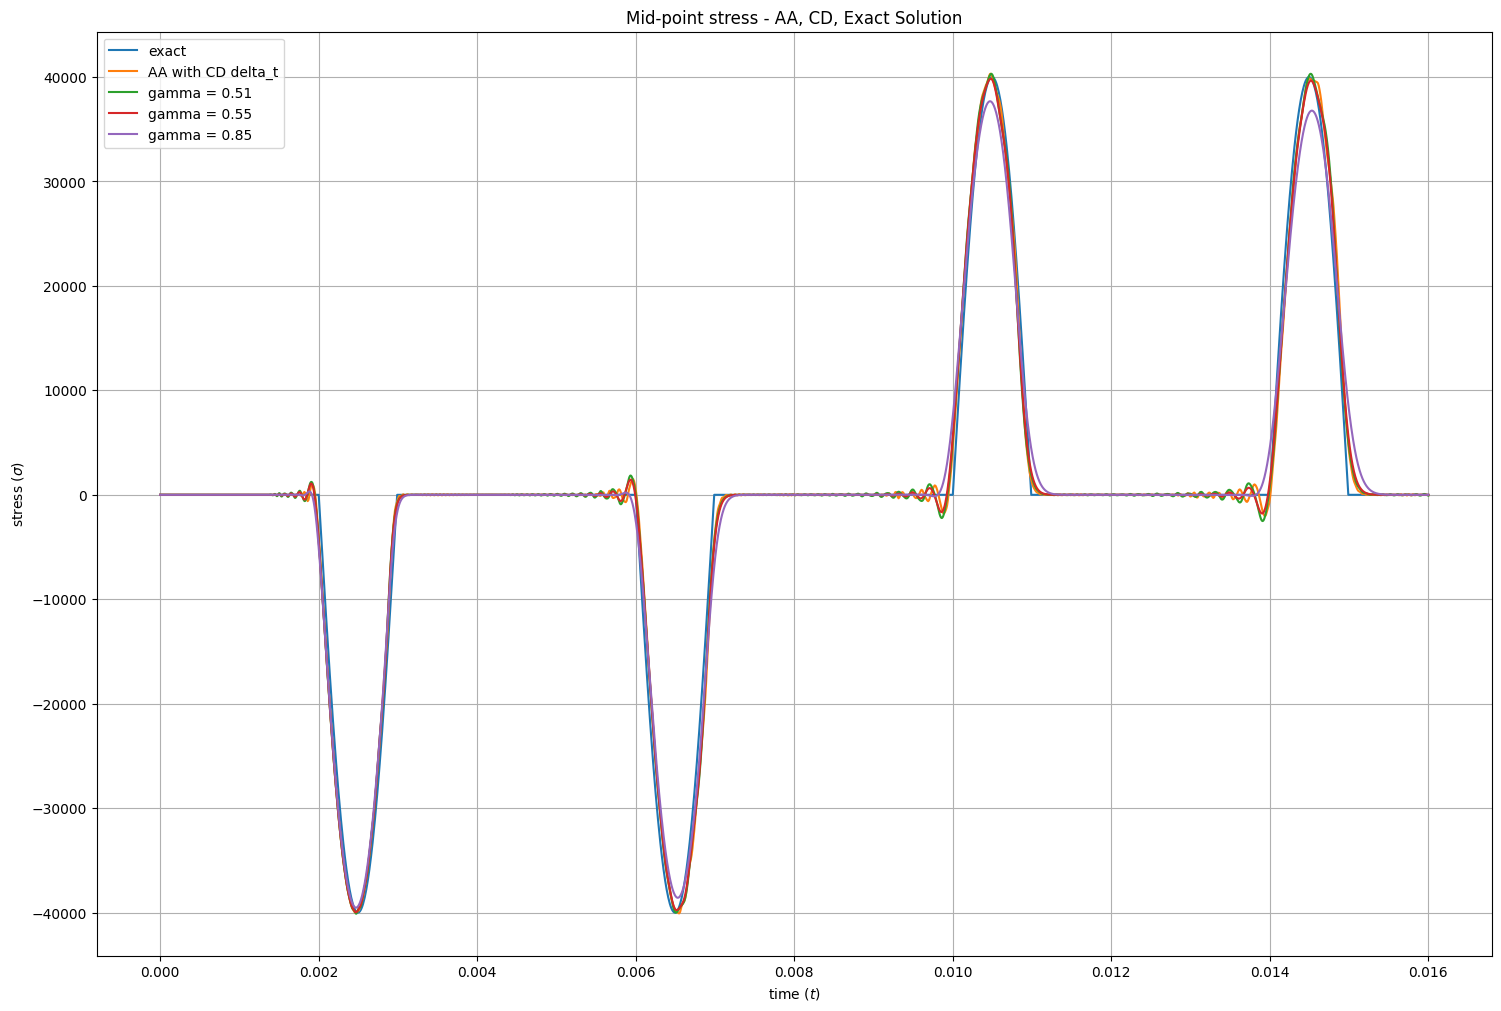

In [12]:
# material properties
gamma_options = [0.51, 0.55, 0.85]

for gamma in gamma_options:
    
    integration_scheme = 'AA'
    
    E = 200e9         # Young's modulus [N/m**2]
    rho_tilde = 8000  # density [kg/m**3]

    multimat = False  # flag for multimaterials 

    # domain data
    L = 20.       # length of the domain [m]
    Ae = 100e-6   # cross sectional area [m**2]

    # loading 
    A_bar = -4e4  # applied traction [N/m**2]

    # mesh data
    n_el = 200                # number of elements
    n_np = n_el + 1           # number of nodal points
    n_dof = n_np              # number of degrees of freedom
    x = np.linspace(0, L, n_np) # x-coordinates of the nodes
    le = L / n_el             # length of an element

    integration_scheme_dict = {
        'AA': [1/4, 1/2],
        'LA': [1/6, 1/2],
        'FG': [1/12, 1/2],
        'CD': [0, 1/2]
    }

    # time integration data
    # see note for further details
    # Newmark method parameters
    #  Scheme |    beta    |   gamma  |
    #   AA*   |    1/4     |   1/2    |
    #   LA    |    1/6     |   1/2    |
    #   FG    |    1/12    |   1/2    |
    #   CD    |    0       |   1/2    |
    # note the AA scheme is unconditionally stable.
    # Newmark parameters
    beta = integration_scheme_dict[integration_scheme][0]
    consistent = True   # use a consistent mass matrix

    T = 0.016   # total time
    c = np.sqrt(E/ rho_tilde)  # wave speed

    # compute the critical time-step
    # note: uncondionally stable AA scheme will return 1.0
    if integration_scheme == 'AA':
        delta_t_crit_AA = get_delta_t_crit(le, gamma_CD, beta_CD , consistent, c)
        delta_t_crit = delta_t_crit_AA
    else:
        delta_t_crit = get_delta_t_crit(le, gamma, beta , consistent, c)
    


    # actual times-step used is a factor of the critical time-step
    reduction_factor = 0.3
    delta_t = reduction_factor * delta_t_crit

    # selected output data is stored to a file with the name given below
    # use this to save the results from the different runs
    # change the name to match the data you want to store
    outfile = local_path + f'\\data\\data_AA_0_9_mass_con_gamma_{gamma}.npz'

    
    print(f"LA Integration Scheme Information")
    print('----------------------------------------------')
    print('beta = %2.3f, \tgamma = %2.3f' %(beta, gamma))
    print('c = %2.3f' %c)
    print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit, delta_t))
    print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
    print('----------------------------------------------')

    n_t_steps = int(np.ceil(T / delta_t));    # number of time step

    # initialise the time domain, K and M
    t = np.linspace(0, T, n_t_steps)
    K = np.zeros((n_dof, n_dof))
    M = np.zeros((n_dof, n_dof))

    # assemble K and M
    for ee in range(n_el):
        dof_index = get_dof_index(ee)

        K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
        M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

    # damping matrix
    C = np.zeros((n_dof, n_dof))

    # assemble the system matrix A
    A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

    # define the free dofs
    free_dof = np.arange(1,n_dof)

    # initial conditions
    d = np.zeros((n_dof, 1))
    v = np.zeros((n_dof, 1))
    F = np.zeros((n_dof, 1))

    # compute the initial acceleration
    a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

    # store the history data 
    # rows -> each node 
    # columns -> each time step including initial at 0
    d_his = np.zeros((n_dof, n_t_steps))
    v_his = np.zeros((n_dof, n_t_steps))
    a_his = np.zeros((n_dof, n_t_steps))
    d_his[:,0] = d[:,0]
    v_his[:,0] = v[:,0]
    a_his[:,0] = a[:,0]

    # loop over the time domain and solve the problem at each step
    for n in range(1,n_t_steps):
        if n % 200 == 0:
            print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

        # data at beginning of the time-step n
        a_n = a
        v_n = v
        d_n = d

        # applied loading
        t_current = n * delta_t # current time
        if t_current<0.001:
            F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
        else:
            F[-1]=0.

        # define predictors
        d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
        v_tilde = v_n + (1 - gamma) * delta_t * a_n

        # assemble the right-hand side from the known data
        R = F - C.dot(v_tilde) - K.dot(d_tilde)

        # impose essential boundary condition and solve A a = RHS
        A_free = A_matrix[np.ix_(free_dof, free_dof)]
        R_free = R[np.ix_(free_dof)]

        # solve for the accelerations at the free nodes
        a_free = np.linalg.solve(A_free, R_free) 
        a = np.zeros((n_dof, 1))
        a[1:] = a_free

        # update displacement and vecloity predictors using the acceleration
        d = d_tilde + (beta * delta_t**2) * a
        v = v_tilde + (gamma * delta_t) * a

        # store solutions
        d_his[:,n] = d[:,0]
        v_his[:,n] = v[:,0]
        a_his[:,n] = a[:,0]

    # post-processing
    mid_node = int(np.ceil(n_dof / 2))  # mid node

    # compute the stress in each element
    # assuming constant E
    stress = (E / le) * np.diff(d_his, axis=0)

    # here we save the stress data for the middle element
    np.savez(outfile, t, stress[mid_node,:])

# load all of the files for the comparison needed to plot
npzfile_exact = np.load(local_path + '\\data\\data_exact.npz')
t_exact = npzfile_exact['arr_0']
stress_exact = npzfile_exact['arr_1']

npzfile_AA = np.load(local_path + f'\\data\\data_AA_0_8_mass_con_0.9.npz')
t_AA = npzfile_AA['arr_0']
stress_AA = npzfile_AA['arr_1']

npzfile_AA_gamma_0_51 = np.load(local_path + f'\\data\\data_AA_0_9_mass_con_gamma_0.51.npz')
t_AA_gamma_0_51 = npzfile_AA_gamma_0_51['arr_0']
stress_AA_gamma_0_51= npzfile_AA_gamma_0_51['arr_1']

npzfile_AA_gamma_0_55 = np.load(local_path + f'\\data\\data_AA_0_9_mass_con_gamma_0.55.npz')
t_AA_gamma_0_55 = npzfile_AA_gamma_0_55['arr_0']
stress_AA_gamma_0_55 = npzfile_AA_gamma_0_55['arr_1']

npzfile_AA_gamma_0_85 = np.load(local_path + f'\\data\\data_AA_0_9_mass_con_gamma_0.85.npz')
t_AA_gamma_0_85 = npzfile_AA_gamma_0_85['arr_0']
stress_AA_gamma_0_85 = npzfile_AA_gamma_0_85['arr_1']

# plot the exact stress versus the FE predicted stress for AA and CD 
plt.figure(figsize = (18, 12))
line1, = plt.plot(t_exact,stress_exact, label = 'exact')
line2, = plt.plot(t_AA,stress_AA, label = 'AA with CD delta_t')
line3, = plt.plot(t_AA_gamma_0_51,stress_AA_gamma_0_51, label = f'gamma = 0.51')
line4, = plt.plot(t_AA_gamma_0_55,stress_AA_gamma_0_55, label = f'gamma = 0.55')
line5, = plt.plot(t_AA_gamma_0_85,stress_AA_gamma_0_85, label = f'gamma = 0.85')

plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress - AA, CD, Exact Solution')
plt.legend(handles=[line1, line2, line3, line4, line5])
plt.grid()
plt.show()



In [13]:
print("Data shape for AA:", stress[mid_node,:].shape)

Data shape for AA: (4619,)


# Question 4
Assume a  $\Delta t  / \Delta t_\text{c} = 0.75$.
Plot the stress history at point A for the central difference scheme for both a consistent mass matrix and a lumped mass matrix.

Superimpose the exact solution on your plots.

Comment on the structure of the matrix $\mathbf{A}$.
Comment on the results.

CD Integration Scheme Information
----------------------------------------------
beta = 0.000, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.155E-05, 	delta_t =  3.464E-06
delta_t / delta_t_crit = 0.750
----------------------------------------------
Time step:  200  , Total time:  0.0017320508075688776  of  0.016
Time step:  400  , Total time:  0.003464101615137755  of  0.016
Time step:  600  , Total time:  0.0051961524227066335  of  0.016
Time step:  800  , Total time:  0.00692820323027551  of  0.016
Time step:  1000  , Total time:  0.008660254037844388  of  0.016
Time step:  1200  , Total time:  0.010392304845413267  of  0.016
Time step:  1400  , Total time:  0.012124355652982144  of  0.016
Time step:  1600  , Total time:  0.01385640646055102  of  0.016
Time step:  1800  , Total time:  0.0155884572681199  of  0.016
Time step:  200  , Total time:  0.0017320508075688776  of  0.016
Time step:  400  , Total time:  0.003464101615137755  of  0.016
Time step:  600  , Total time:  0.00519615

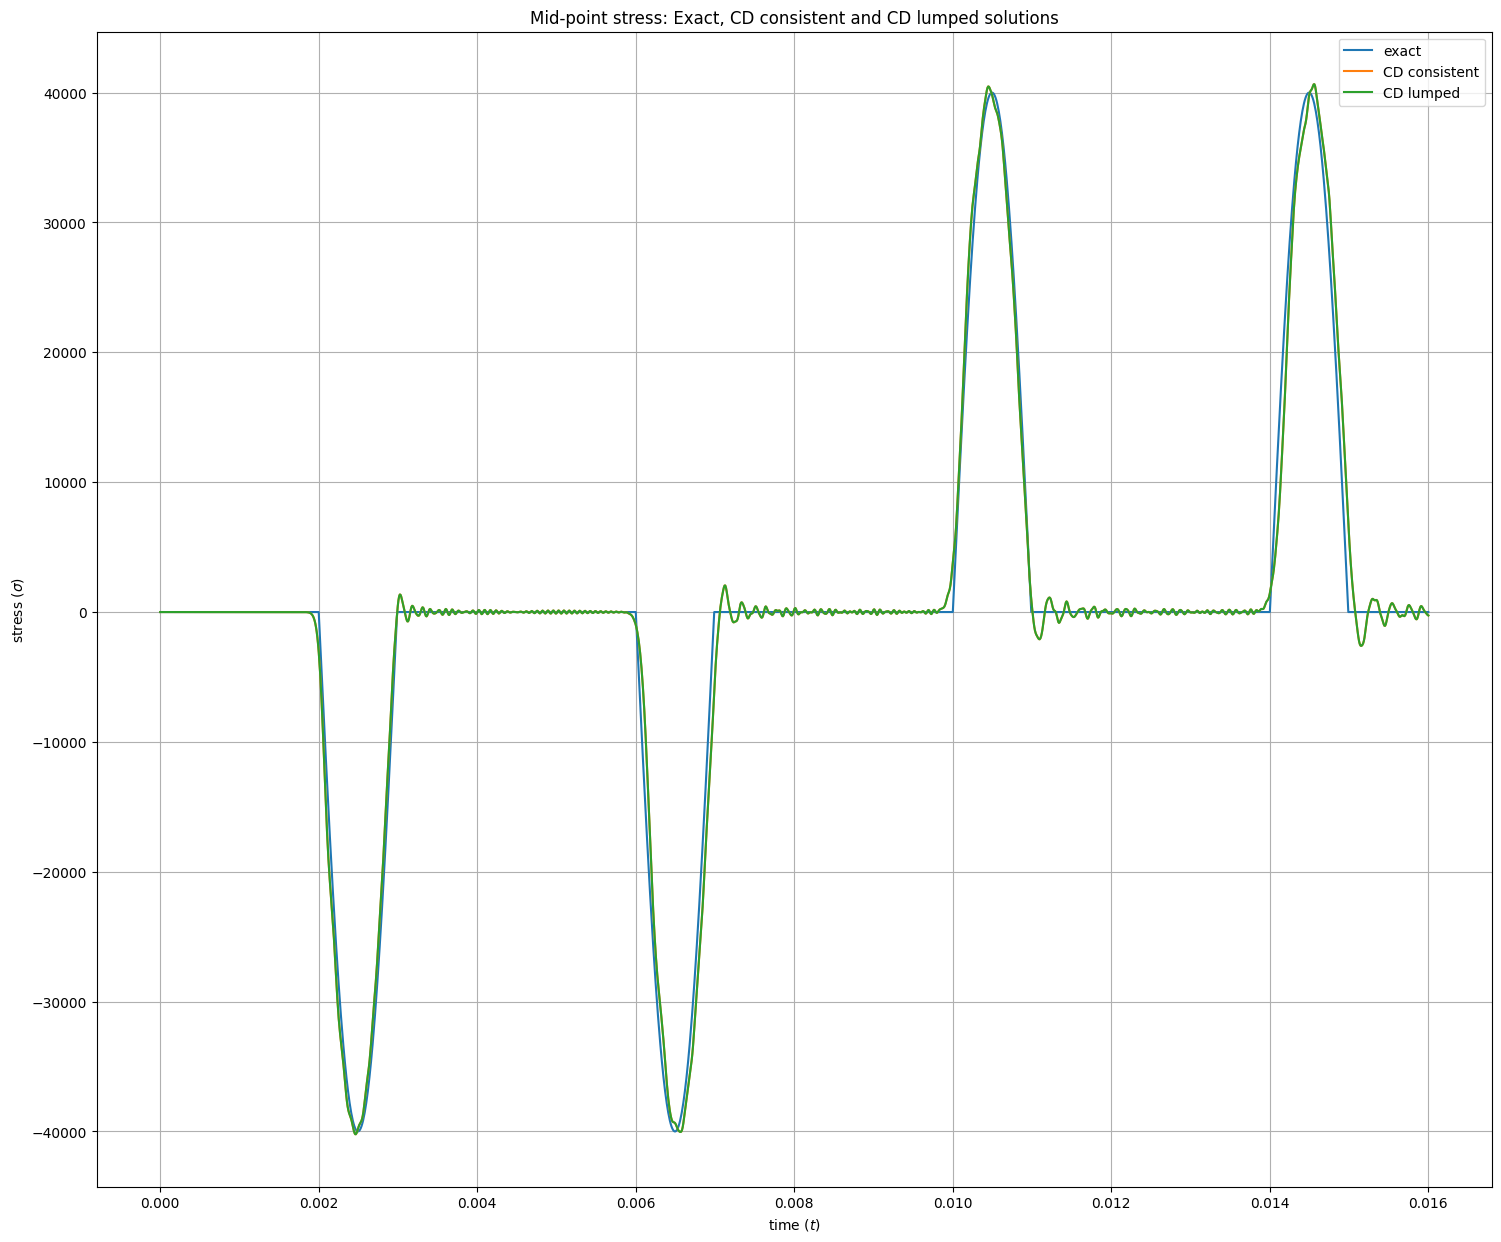

In [14]:
# material properties
E = 200e9         # Young's modulus [N/m**2]
rho_tilde = 8000  # density [kg/m**3]

multimat = False  # flag for multimaterials 

# domain data
L = 20.       # length of the domain [m]
Ae = 100e-6   # cross sectional area [m**2]

# loading 
A_bar = -4e4  # applied traction [N/m**2]

# mesh data
n_el = 200                # number of elements
n_np = n_el + 1           # number of nodal points
n_dof = n_np              # number of degrees of freedom
x = np.linspace(0, L, n_np) # x-coordinates of the nodes
le = L / n_el             # length of an element

# time integration data
# see note for further details
# Newmark method parameters
#  Scheme |    beta    |   gamma  |
#   AA*   |    1/4     |   1/2    |
#   LA    |    1/6     |   1/2    |
#   FG    |    1/12    |   1/2    |
#   CD    |    0       |   1/2    |
# note the AA scheme is unconditionally stable.
# Newmark parameters
beta = 0
gamma = 1./2
consistent = True   # use a consistent mass matrix

T = 0.016   # total time
c = np.sqrt(E/ rho_tilde)  # wave speed

# compute the critical time-step
# note: uncondionally stable AA scheme will return 1.0
delta_t_crit_consistent = get_delta_t_crit(le, gamma, beta , consistent, c)
consistent = False
delta_t_crit_lumped = get_delta_t_crit(le, gamma, beta , consistent, c)

# actual times-step used is a factor of the critical time-step
reduction_factor = 0.75

delta_t_consistent = reduction_factor * delta_t_crit_consistent
delta_t_lumped = reduction_factor * delta_t_crit_lumped

# selected output data is stored to a file with the name given below
# use this to save the results from the different runs
# change the name to match the data you want to store for both the consistent and lumped mass matrices

outfile_consistent = local_path + f'\\data\\data_LA_10_mass_con{reduction_factor}.npz'
outfile_lumped = local_path + f'\\data\\data_LA_10_mass_lumped{reduction_factor}.npz'

print(f"CD Integration Scheme Information")
print('----------------------------------------------')
print('beta = %2.3f, \tgamma = %2.3f' %(beta, gamma))
print('c = %2.3f' %c)
print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit, delta_t))
print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
print('----------------------------------------------')

      # ----------------------
    
delta_t = delta_t_consistent
delta_t_crit = delta_t_crit_consistent
outfile = outfile_consistent

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
    dof_index = get_dof_index(ee)

    K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
    M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
        if n % 200 == 0:
            print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

        # data at beginning of the time-step n
        a_n = a
        v_n = v
        d_n = d

        # applied loading
        t_current = n * delta_t # current time
        
        if t_current<0.001:
            F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
        else:
            F[-1]=0.

        # define predictors
        d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
        v_tilde = v_n + (1 - gamma) * delta_t * a_n

        # assemble the right-hand side from the known data
        R = F - C.dot(v_tilde) - K.dot(d_tilde)

        # impose essential boundary condition and solve A a = RHS
        A_free = A_matrix[np.ix_(free_dof, free_dof)]
        R_free = R[np.ix_(free_dof)]

        # solve for the accelerations at the free nodes
        a_free = np.linalg.solve(A_free, R_free) 
        a = np.zeros((n_dof, 1))
        a[1:] = a_free

        # update displacement and vecloity predictors using the acceleration
        d = d_tilde + (beta * delta_t**2) * a
        v = v_tilde + (gamma * delta_t) * a

        # store solutions
        d_his[:,n] = d[:,0]
        v_his[:,n] = v[:,0]
        a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

delta_t = delta_t_consistent
delta_t_crit = delta_t_crit_consistent
outfile = outfile_lumped

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
    dof_index = get_dof_index(ee)

    K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
    M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
    if n % 200 == 0:
        print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)
  # data at beginning of the time-step n
    a_n = a
    v_n = v
    d_n = d
    
    # applied loading
    t_current = n * delta_t # current time
    if t_current<0.001:
        F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
    else:
        F[-1]=0.
    
    # define predictors
    d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
    v_tilde = v_n + (1 - gamma) * delta_t * a_n
    
    # assemble the right-hand side from the known data
    R = F - C.dot(v_tilde) - K.dot(d_tilde)
    
    # impose essential boundary condition and solve A a = RHS
    A_free = A_matrix[np.ix_(free_dof, free_dof)]
    R_free = R[np.ix_(free_dof)]

    # solve for the accelerations at the free nodes
    a_free = np.linalg.solve(A_free, R_free) 
    a = np.zeros((n_dof, 1))
    a[1:] = a_free

    # update displacement and vecloity predictors using the acceleration
    d = d_tilde + (beta * delta_t**2) * a
    v = v_tilde + (gamma * delta_t) * a
    
    # store solutions
    d_his[:,n] = d[:,0]
    v_his[:,n] = v[:,0]
    a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

      # ----------------------

delta_t = delta_t_lumped
delta_t_crit = delta_t_crit_lumped
outfile = outfile_lumped

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
    dof_index = get_dof_index(ee)

    K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
    M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
    if n % 200 == 0:
        print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

    # data at beginning of the time-step n
    a_n = a
    v_n = v
    d_n = d

    # applied loading
    t_current = n * delta_t # current time
    
    if t_current<0.001:
        F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
    else:
        F[-1]=0.

    # define predictors
    d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
    v_tilde = v_n + (1 - gamma) * delta_t * a_n

    # assemble the right-hand side from the known data
    R = F - C.dot(v_tilde) - K.dot(d_tilde)

    # impose essential boundary condition and solve A a = RHS
    A_free = A_matrix[np.ix_(free_dof, free_dof)]
    R_free = R[np.ix_(free_dof)]

    # solve for the accelerations at the free nodes
    a_free = np.linalg.solve(A_free, R_free) 
    a = np.zeros((n_dof, 1))
    a[1:] = a_free

    # update displacement and vecloity predictors using the acceleration
    d = d_tilde + (beta * delta_t**2) * a
    v = v_tilde + (gamma * delta_t) * a

    # store solutions
    d_his[:,n] = d[:,0]
    v_his[:,n] = v[:,0]
    a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

delta_t = delta_t_consistent
delta_t_crit = delta_t_crit_consistent
outfile = outfile_lumped

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
    dof_index = get_dof_index(ee)

    K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
    M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
    if n % 200 == 0:
        print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

    # data at beginning of the time-step n
    a_n = a
    v_n = v
    d_n = d

    # applied loading
    t_current = n * delta_t # current time
    if t_current<0.001:
        F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
    else:
        F[-1]=0.

    # define predictors
    d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
    v_tilde = v_n + (1 - gamma) * delta_t * a_n

    # assemble the right-hand side from the known data
    R = F - C.dot(v_tilde) - K.dot(d_tilde)

    # impose essential boundary condition and solve A a = RHS
    A_free = A_matrix[np.ix_(free_dof, free_dof)]
    R_free = R[np.ix_(free_dof)]

    # solve for the accelerations at the free nodes
    a_free = np.linalg.solve(A_free, R_free) 
    a = np.zeros((n_dof, 1))
    a[1:] = a_free

    # update displacement and vecloity predictors using the acceleration
    d = d_tilde + (beta * delta_t**2) * a
    v = v_tilde + (gamma * delta_t) * a

    # store solutions
    d_his[:,n] = d[:,0]
    v_his[:,n] = v[:,0]
    a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

      # ----------------------
    
npzfile_exact = np.load(local_path + '\\data\\data_exact.npz')
t_exact = npzfile_exact['arr_0']
stress_exact = npzfile_exact['arr_1']

npzfile_CD_con = np.load(local_path +  f'\\data\\data_LA_10_mass_con{reduction_factor}.npz')
t_CD_con = npzfile_CD_con['arr_0']
stress_CD_con = npzfile_CD_con['arr_1']

npzfile_CD_lumped = np.load(local_path + f'\\data\\data_LA_10_mass_lumped{reduction_factor}.npz')
t_CD_lumped = npzfile_CD_lumped['arr_0']
stress_CD_lumped = npzfile_CD_lumped['arr_1']

      # ----------------------
    
# plot the exact stress versus the FE predicted stress
plt.figure(figsize = (18, 15))
line1, = plt.plot(t_exact, stress_exact, label = 'exact')
line2, = plt.plot(t_CD_con,stress_CD_con, label = 'CD consistent')
line3, = plt.plot(t_CD_lumped,stress_CD_lumped, label = 'CD lumped')

plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress: Exact, CD consistent and CD lumped solutions')
plt.legend(handles=[line1, line2, line3])
plt.grid()
plt.show()


# Question 5
Now consider a bar where the Young's modulus $E=200$ GPa for $0 \leq x \leq 0.25 L$ and $E=400$ GPa for $0.25 L < x \leq L$.
Assume a lumped mass matrix and use the Fox Goodwin scheme.

What is the critical time step size?
<br></br>
The critical time step will be a function of the changing Young's Modulus as a result of change in position. 
<br></br>
For a stable time-step choice, plot the stress history at point A and try to explain your results. 

In [29]:
def get_youngs_modulus_as_function_position(x):
     
    if x < (1/4 * (n_el + 1)):
        return 200e9
    return 400e9


In [30]:
integration_scheme = 'FG'
# material properties, the Young's Modulus E will be a function of the position
rho_tilde = 8000  # density [kg/m**3]

multimat = False  # flag for multimaterials 

E1 = 200e9
E2 = 400e9

integration_scheme_dict = {
    'AA': [1/4, 1/2],
    'LA': [1/6, 1/2],
    'FG': [1/12, 1/2],
    'CD': [0, 1/2]
}

beta = integration_scheme_dict[integration_scheme][0]
gamma = integration_scheme_dict[integration_scheme][1]

consistent = False   # use a consistent mass matrix

T = 0.016   # total time
c1 = np.sqrt(E1/ rho_tilde)  # wave speed for E1
c2 = np.sqrt(E2/ rho_tilde)  # wave speed for E2

# compute the critical time-step
# note: uncondionally stable AA scheme will return 1.0
delta_t_crit_E1 = get_delta_t_crit(le, gamma, beta , consistent, c1)
delta_t_crit_E2 = get_delta_t_crit(le, gamma, beta , consistent, c2)

print(f"Critical Time Step Information")
print('----------------------------------------------')
print(f"The Critical time step size is different for both of the parts of the beam, since there is change in the Young's modulus:"
        f"\n delta_t_crit_E1 = {delta_t_crit_E1}\n delta_t_crit_E2 = {delta_t_crit_E2}")
print('----------------------------------------------')

Critical Time Step Information
----------------------------------------------
The Critical time step size is different for both of the parts of the beam, since there is change in the Young's modulus:
 delta_t_crit_E1 = 2.4494897427831778e-05
 delta_t_crit_E2 = 1.7320508075688774e-05
----------------------------------------------


There could be two approaches for solving the time dependent problem in Question 5:
<br></br>

* **Choosing the smaller critical time step** - By choosing the smaller critical time step across the entire length of the bar we ensure that the time step, with applied reduction factor of less than 1 will always be less than the local critical time step across the entire bar. This means that we will have a smaller time step for the entire length, even in positions where that is not needed, leading to a computationally heavier algorithm.
* **Calculating the critical time step locally** - By choosing to calculate the critical time step as a function of the position just as we did with the bar's Young's modulus we ensure we will need less time steps, leading to a computationally lighter algorithm. However this approach also has a few disadvantages - inconsistency in choosing the time step might lead to unreasonable modeling assumptions. Another aspect to consider in the second critical time step calculation process is the fact that we will need to introduce further algorithm complexity.
<br></br>

While both options are feasible for solving this problem, here l have chosen to implement the first, more simple calculation approach, calculating the critical time step for both Young's moduli, choosing the smaller and then calculating the actual time step as a function of the reduction factor and this smaller critical time step.
<br></br>


In [31]:
print(f"Smaller Critical time step of the two = {delta_t_crit_E1 if delta_t_crit_E1 <= delta_t_crit_E2 else delta_t_crit_E2} s.")

Smaller Critical time step of the two = 1.7320508075688774e-05 s.


LA Integration Scheme Information
----------------------------------------------
beta = 0.083, 	gamma = 0.500
c = 5000.000
delta_t_crit =  1.732E-05, 	delta_t =  8.660E-06
delta_t / delta_t_crit = 0.500
----------------------------------------------
Time step:  200  , Total time:  0.0017320508075688774  of  0.016
Time step:  400  , Total time:  0.0034641016151377548  of  0.016
Time step:  600  , Total time:  0.005196152422706632  of  0.016
Time step:  800  , Total time:  0.0069282032302755096  of  0.016
Time step:  1000  , Total time:  0.008660254037844387  of  0.016
Time step:  1200  , Total time:  0.010392304845413263  of  0.016
Time step:  1400  , Total time:  0.012124355652982142  of  0.016
Time step:  1600  , Total time:  0.013856406460551019  of  0.016
Time step:  1800  , Total time:  0.015588457268119896  of  0.016


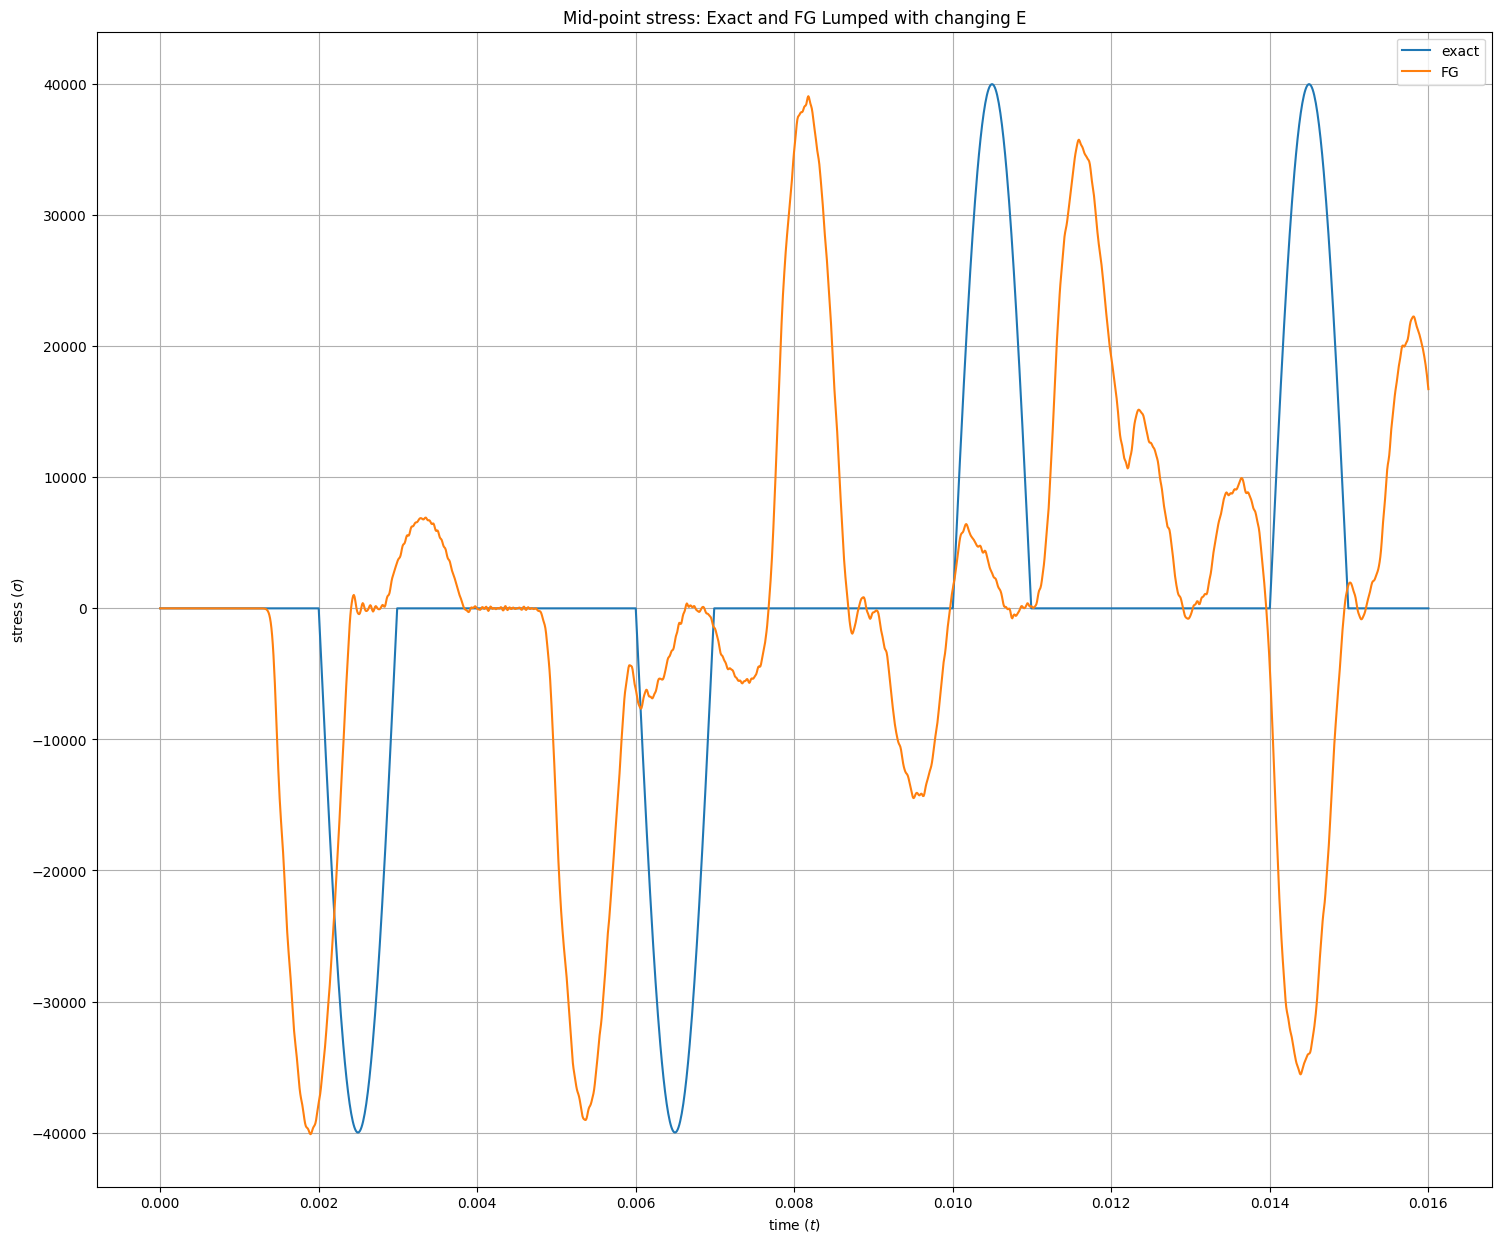

In [32]:
integration_scheme = 'FG'

# material properties, the Young's Modulus E will be a function of the position
rho_tilde = 8000  # density [kg/m**3]

multimat = False  # flag for multimaterials 

# domain data
L = 20.       # length of the domain [m]
Ae = 100e-6   # cross sectional area [m**2]

# loading 
A_bar = -4e4  # applied traction [N/m**2]

# mesh data
n_el = 200                  # number of elements
n_np = n_el + 1             # number of nodal points
n_dof = n_np                # number of degrees of freedom
x = np.linspace(0, L, n_np) # x-coordinates of the nodes
le = L / n_el               # length of an element

integration_scheme_dict = {
    'AA': [1/4, 1/2],
    'LA': [1/6, 1/2],
    'FG': [1/12, 1/2],
    'CD': [0, 1/2]
}

beta = integration_scheme_dict[integration_scheme][0]
gamma = integration_scheme_dict[integration_scheme][1]

consistent = False   # use a consistent mass matrix

T = 0.016   # total time
c = np.sqrt(E/ rho_tilde)  # wave speed

# compute the critical time-step
# note: uncondionally stable AA scheme will return 1.0
delta_t_crit = delta_t_crit_E1 if delta_t_crit_E1 <= delta_t_crit_E2 else delta_t_crit_E2

# actual times-step used is a factor of the critical time-step, here we have chosen a reduction_factor of 0.5 to keep the delta_t under the critical value, resulting
# in a satisfied condition for the conditionally stable Fox Goodwin integration scheme.
reduction_factor = 0.5
delta_t = reduction_factor * delta_t_crit

# selected output data is stored to a file with the name given below
# use this to save the results from the different runs
# change the name to match the data you want to store
outfile = local_path + '\\data\\data_FG_11_mass_lumped_changing_E.npz'

print(f"LA Integration Scheme Information")
print('----------------------------------------------')
print('beta = %2.3f, \tgamma = %2.3f' %(beta, gamma))
print('c = %2.3f' %c)
print('delta_t_crit = %10.3E, \tdelta_t = %10.3E' %(delta_t_crit, delta_t))
print('delta_t / delta_t_crit = %2.3f' %(reduction_factor))
print('----------------------------------------------')

n_t_steps = int(np.ceil(T / delta_t));    # number of time step

# initialise the time domain, K and M
t = np.linspace(0, T, n_t_steps)
K = np.zeros((n_dof, n_dof))
M = np.zeros((n_dof, n_dof))

# assemble K and M
for ee in range(n_el):
    dof_index = get_dof_index(ee)
        
    E = get_youngs_modulus_as_function_position(ee)

    K[np.ix_(dof_index, dof_index)] +=  get_Ke(Ae, E, le)
    M[np.ix_(dof_index, dof_index)] +=  get_Me(Ae, rho_tilde, le, consistent)

# damping matrix
C = np.zeros((n_dof, n_dof))

# assemble the system matrix A
A_matrix = M + (gamma * delta_t) * C + (beta * delta_t**2)*K 

# define the free dofs
free_dof = np.arange(1,n_dof)

# initial conditions
d = np.zeros((n_dof, 1))
v = np.zeros((n_dof, 1))
F = np.zeros((n_dof, 1))

# compute the initial acceleration
a = np.linalg.solve(M, F - C.dot(v) - K.dot(d))

# store the history data 
# rows -> each node 
# columns -> each time step including initial at 0
d_his = np.zeros((n_dof, n_t_steps))
v_his = np.zeros((n_dof, n_t_steps))
a_his = np.zeros((n_dof, n_t_steps))
d_his[:,0] = d[:,0]
v_his[:,0] = v[:,0]
a_his[:,0] = a[:,0]

# loop over the time domain and solve the problem at each step
for n in range(1,n_t_steps):
    if n % 200 == 0:
        print('Time step: ', n, ' , Total time: ', n*delta_t, ' of ', T)

    # data at beginning of the time-step n
    a_n = a
    v_n = v
    d_n = d

    # applied loading
    t_current = n * delta_t # current time
    
    if t_current<0.001:
        F[-1] = A_bar * Ae * np.sin(1000 * t_current * np.pi)
    else:
        F[-1]=0.

    # define predictors
    d_tilde = d_n + delta_t*v_n + ((delta_t**2)/2.) * (1 - 2*beta) * a_n
    v_tilde = v_n + (1 - gamma) * delta_t * a_n

    # assemble the right-hand side from the known data
    R = F - C.dot(v_tilde) - K.dot(d_tilde)

    # impose essential boundary condition and solve A a = RHS
    A_free = A_matrix[np.ix_(free_dof, free_dof)]
    R_free = R[np.ix_(free_dof)]

    # solve for the accelerations at the free nodes
    a_free = np.linalg.solve(A_free, R_free) 
    a = np.zeros((n_dof, 1))
    a[1:] = a_free

    # update displacement and vecloity predictors using the acceleration
    d = d_tilde + (beta * delta_t**2) * a
    v = v_tilde + (gamma * delta_t) * a

    # store solutions
    d_his[:,n] = d[:,0]
    v_his[:,n] = v[:,0]
    a_his[:,n] = a[:,0]

# post-processing
mid_node = int(np.ceil(n_dof / 2))  # mid node

# compute the stress in each element
# assuming constant E
stress = (E / le) * np.diff(d_his, axis=0)

# here we save the stress data for the middle element
np.savez(outfile, t, stress[mid_node,:])

npzfile_exact = np.load(local_path + '\\data\\data_exact.npz')
t_exact = npzfile_exact['arr_0']
stress_exact = npzfile_exact['arr_1']

npzfile_FG_11 = np.load(local_path +  f"\\data\\data_FG_11_mass_lumped_changing_E.npz")
t_FG_11 = npzfile_FG_11['arr_0']
stress_FG_11 = npzfile_FG_11['arr_1']

      # ----------------------
    
# plot the exact stress versus the FE predicted stress
plt.figure(figsize = (18, 15))
line1, = plt.plot(t_exact, stress_exact, label = 'exact')
line2, = plt.plot(t_FG_11, stress_FG_11, label = 'FG')

plt.xlabel('time ($t$)')
plt.ylabel('stress ($\sigma$)')
plt.title('Mid-point stress: Exact and FG Lumped with changing E')
plt.legend(handles=[line1, line2])
plt.grid()
plt.show()